## Расчет свойств сталей с помощью моделей МО

### Импорт нужных библиотек

In [24]:
from matminer.datasets import get_available_datasets, load_dataset
import numpy as np
import pandas as pd

In [25]:
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib
import matplotlib.cm as cm
from catboost import CatBoostRegressor

import seaborn as sns

In [26]:
plt.rcParams.update({'font.size': 20})

### загружаем датасет

In [27]:
get_available_datasets()

boltztrap_mp: Effective mass and thermoelectric properties of 8924 compounds in The  Materials Project database that are calculated by the BoltzTraP software package run on the GGA-PBE or GGA+U density functional theory calculation results. The properties are reported at the temperature of 300 Kelvin and the carrier concentration of 1e18 1/cm3.

brgoch_superhard_training: 2574 materials used for training regressors that predict shear and bulk modulus.

castelli_perovskites: 18,928 perovskites generated with ABX combinatorics, calculating gllbsc band gap and pbe structure, and also reporting absolute band edge positions and heat of formation.

citrine_thermal_conductivity: Thermal conductivity of 872 compounds measured experimentally and retrieved from Citrine database from various references. The reported values are measured at various temperatures of which 295 are at room temperature.

dielectric_constant: 1,056 structures with dielectric properties, calculated with DFPT-PBE.

double_

['boltztrap_mp',
 'brgoch_superhard_training',
 'castelli_perovskites',
 'citrine_thermal_conductivity',
 'dielectric_constant',
 'double_perovskites_gap',
 'double_perovskites_gap_lumo',
 'elastic_tensor_2015',
 'expt_formation_enthalpy',
 'expt_formation_enthalpy_kingsbury',
 'expt_gap',
 'expt_gap_kingsbury',
 'flla',
 'glass_binary',
 'glass_binary_v2',
 'glass_ternary_hipt',
 'glass_ternary_landolt',
 'heusler_magnetic',
 'jarvis_dft_2d',
 'jarvis_dft_3d',
 'jarvis_ml_dft_training',
 'm2ax',
 'matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels',
 'mp_all_20181018',
 'mp_nostruct_20181018',
 'phonon_dielectric_mp',
 'piezoelectric_tensor',
 'ricci_boltztrap_mp_tabular',
 'steel_strength',
 'superconductivity2018',
 'tholander_nitrides',
 'ucsb_thermoe

In [28]:
df = load_dataset('steel_strength')

In [29]:
df.head()

formula     c    mn    si     cr  \
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...  0.02  0.05  0.05   0.01   
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....  0.18  0.01  0.01  13.44   
2  Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....  0.00  0.01  0.01   8.67   
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...  0.01  0.05  0.05   0.01   
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...  0.01  0.05  0.05   0.01   

      ni    mo     v     n    nb     co     w    al    ti  yield strength  \
0  19.70  2.95  0.01  0.00  0.01  15.00  0.00  0.15  1.55          2411.5   
1   0.01  3.01  0.46  0.04  0.01  19.46  2.35  0.04  0.00          1123.1   
2  13.45  0.82  0.01  0.00  0.01  13.90  0.00  0.39  0.57          1736.3   
3  17.70  3.95  0.01  0.00  0.01  15.00  0.00  0.13  1.47          2487.3   
4  19.40  1.45  0.01  0.00  0.01  14.90  0.00  0.13  1.55          2249.6   

   tensile strength  elongation  
0            2473.5         7.0  
1            1929.2         8.0  
2            1871.8         NaN  
3            2514.9         9.0  
4            2315.0         8.5

In [30]:
df.shape

(312, 17)

In [31]:
df.columns

Index(['formula', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w',
       'al', 'ti', 'yield strength', 'tensile strength', 'elongation'],
      dtype='object')

<Axes: >

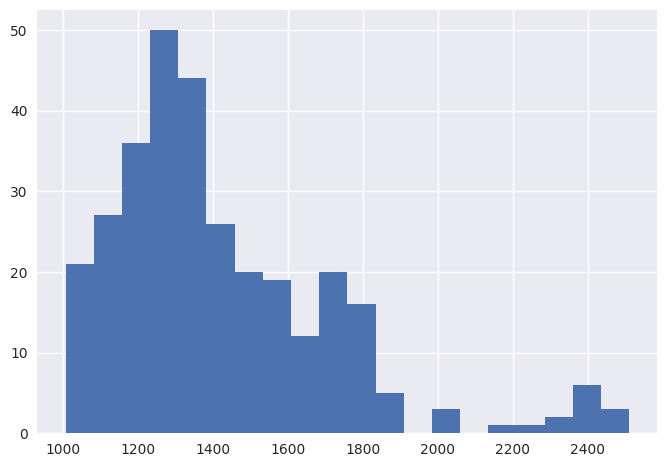

In [32]:
df['yield strength'].hist(bins=20)

In [33]:
df.describe()

c          mn          si          cr          ni          mo  \
count  312.000000  312.000000  312.000000  312.000000  312.000000  312.000000   
mean     0.096442    0.146250    0.221218    8.043830    8.184006    2.766090   
std      0.109008    0.397102    0.580796    5.426169    6.337055    1.832908   
min      0.000000    0.010000    0.010000    0.010000    0.010000    0.020000   
25%      0.010000    0.010000    0.010000    3.100000    0.960000    1.500000   
50%      0.030000    0.010000    0.010000    9.050000    8.500000    2.210000   
75%      0.182500    0.080000    0.110000   12.520000   12.117500    4.090000   
max      0.430000    3.000000    4.750000   17.500000   21.000000    9.670000   

                v           n          nb          co           w          al  \
count  312.000000  312.000000  312.000000  312.000000  312.000000  312.000000   
mean     0.183750    0.005545    0.035449    7.008782    0.161282    0.239135   
std      0.452462    0.018331    0.161537    6.254431    0.920211    0.340110   
min      0.000000    0.000000    0.000000    0.010000    0.000000    0.010000   
25%      0.010000    0.000000    0.010000    0.010000    0.000000    0.030000   
50%      0.010000    0.000000    0.010000    7.085000    0.000000    0.050000   
75%      0.127500    0.000000    0.010000   13.480000    0.000000    0.300000   
max      4.320000    0.150000    2.500000   20.100000    9.180000    1.800000   

               ti  yield strength  tensile strength  elongation  
count  312.000000      312.000000        312.000000  303.000000  
mean     0.310897     1420.998397       1641.653205   14.007261  
std      0.556593      301.894169        346.475179    5.095974  
min      0.000000     1005.900000       1019.000000    2.000000  
25%      0.000000     1219.475000       1338.125000   10.800000  
50%      0.030000     1344.200000       1666.300000   14.800000  
75%      0.232500     1576.075000       1899.950000   17.300000  
max      2.500000     2510.300000       2570.000000   35.000000

### обучаем модель на концентрациях

In [34]:
# разбивка данных на обучающую и тестовые выборки 
X = df[['c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
Y = df['yield strength']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=42)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Объявление объекта класса линейной регрессии
lr = LinearRegression()

In [37]:
# Обучение модели
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
# Расчет свойств на тестовой выборке
y_pred = lr.predict(X_test)

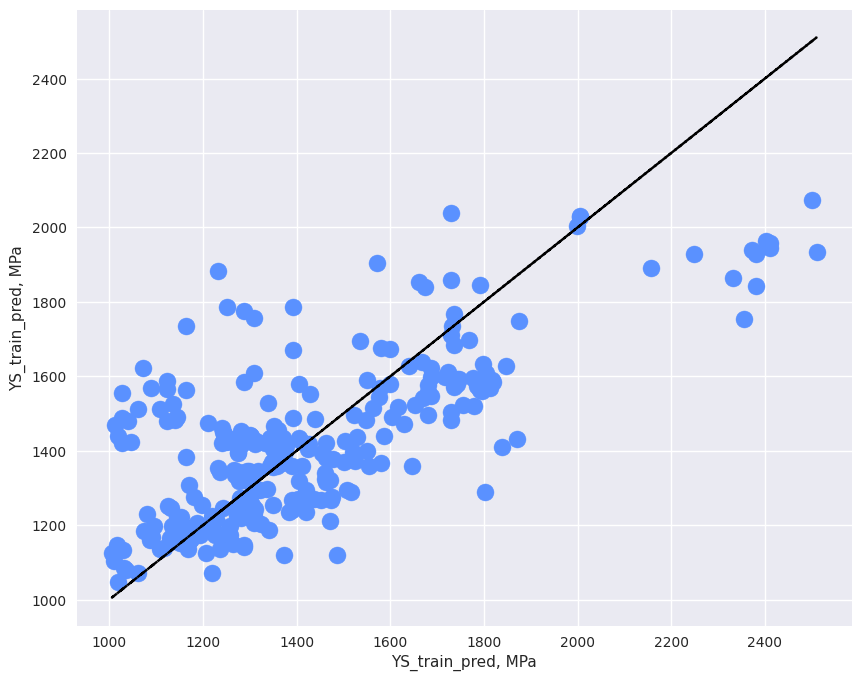

In [39]:
# Работа модели на обучающей выборке
fig = plt.figure(figsize=(10,8))
plt.scatter(y_train, lr.predict(X_train), color = '#5A91FF', s=150)
plt.plot(y_train, y_train, '--k')
plt.xlabel('YS_train_pred, MPa', )
plt.ylabel('YS_train_pred, MPa')
plt.show()

In [40]:
rmse_train = np.sqrt(mse(y_train, lr.predict(X_train)))

In [41]:
rmse_train

208.02021366748536

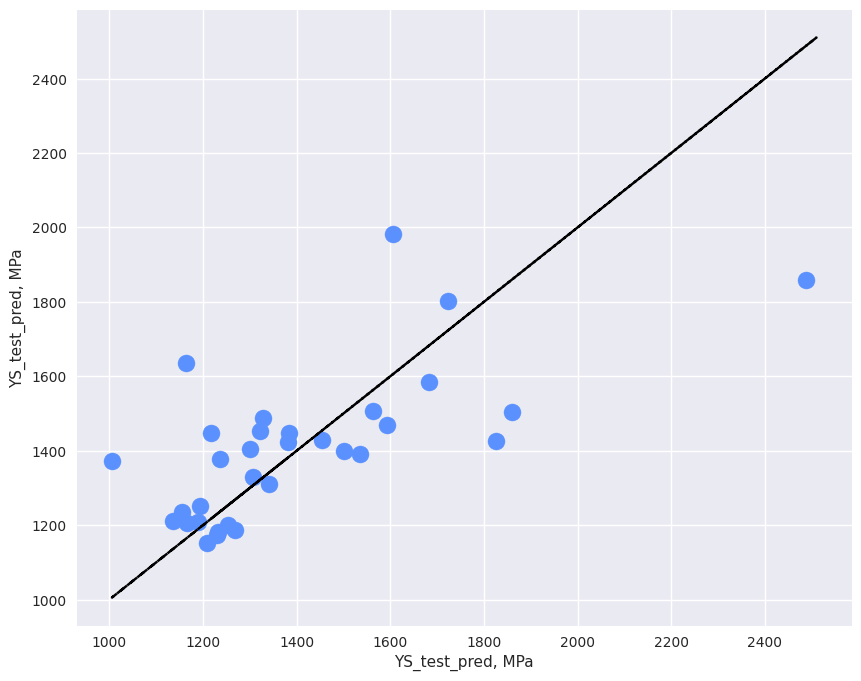

In [42]:
# Работа модели на тестовой выборке
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, color = '#5A91FF', s=150)
plt.plot(y_train, y_train, '--k')
plt.xlabel('YS_test_pred, MPa', )
plt.ylabel('YS_test_pred, MPa')
plt.show()

In [43]:
rmse_test = np.sqrt(mse(y_test, y_pred))

In [44]:
rmse_test

210.2622619991344

In [45]:
# Объявление объекта класса градиентного бустинга CatBoost
cb = CatBoostRegressor()

In [46]:
cb.fit(X_train, y_train, verbose=0)

In [47]:
y_pred = cb.predict(X_test)

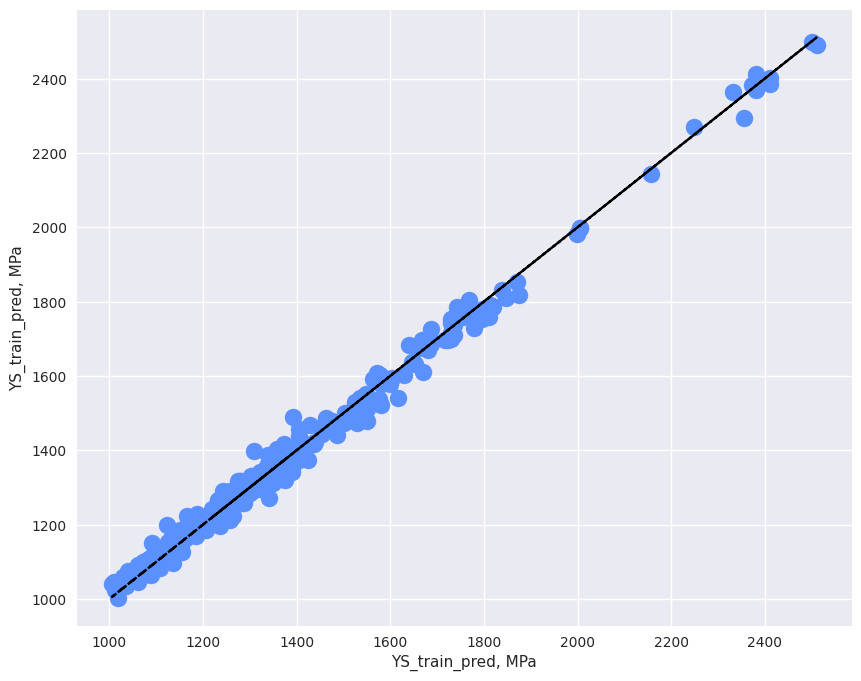

In [48]:
# Работа модели на обучающей выборке
fig = plt.figure(figsize=(10,8))
plt.scatter(y_train, cb.predict(X_train), color = '#5A91FF', s=150)
plt.plot(y_train, y_train, '--k')
plt.xlabel('YS_train_pred, MPa', )
plt.ylabel('YS_train_pred, MPa')
plt.show()

In [49]:
rmse_train = np.sqrt(mse(y_train, cb.predict(X_train)))

In [50]:
rmse_train

27.078967468139886

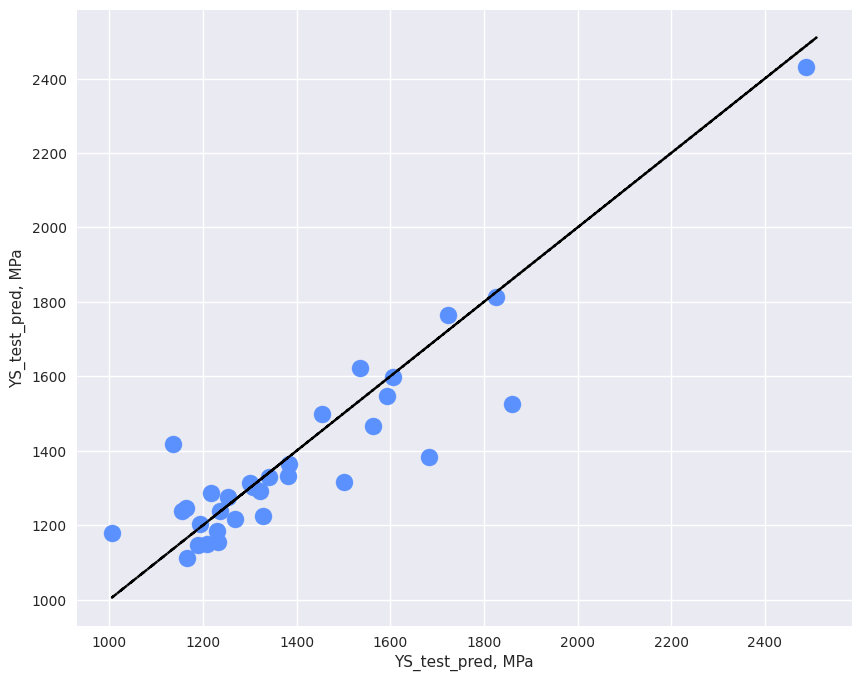

In [51]:
# Работа модели на тестовой выборке
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, color = '#5A91FF', s=150)
plt.plot(y_train, y_train, '--k')
plt.xlabel('YS_test_pred, MPa', )
plt.ylabel('YS_test_pred, MPa')
plt.show()

In [52]:
rmse_test = np.sqrt(mse(y_test, cb.predict(X_test)))

In [53]:
rmse_test

115.0720571217482

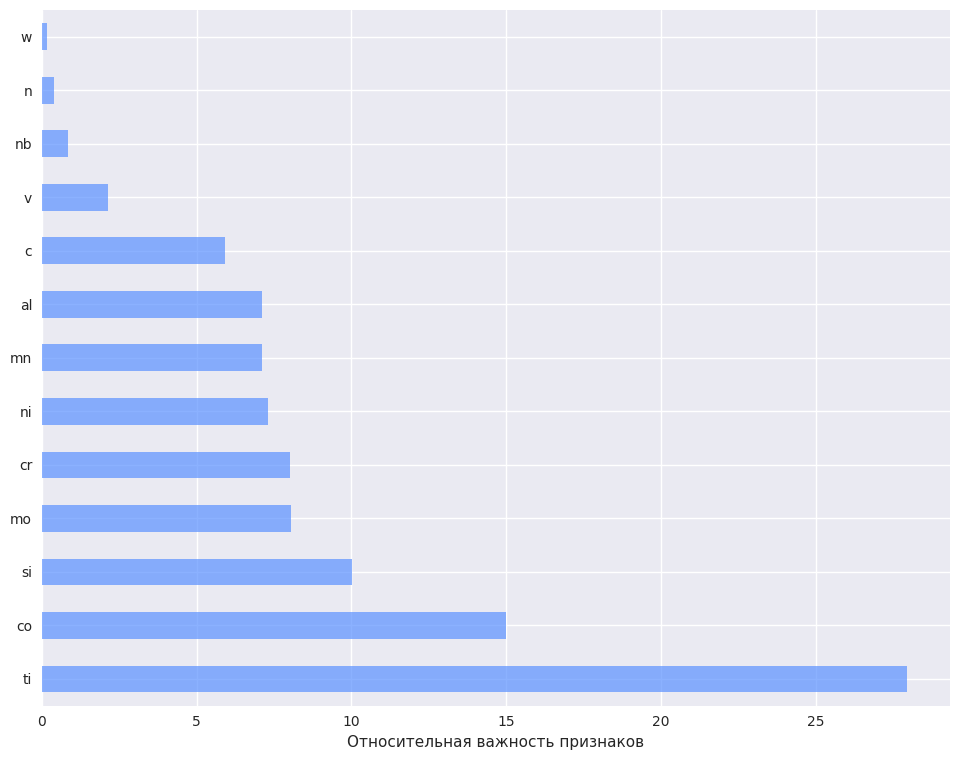

In [54]:
# Важность признаков
fig = plt.figure(figsize=(10,8))
feat_importances = pd.Series(cb.get_feature_importance(), index=X.columns)
feat_importances.nlargest(50).plot(kind='barh', color = '#5A91FF', alpha=0.7)
plt.xlabel('Относительная важность признаков')
plt.tight_layout()

### Задание

1.  Рассчитать score на кросс-валидации для моделей LinearRegression и CatBoost
2.  Обучить нейронную сеть (MLPRegressor) и подобрать оптимальные гиперпараметры
3.  Сравнить полученные score разных алгоритмов
4.  Придумать новые признаки модели, которые будут давать меньшую ошибку на кросс-валидации

### Расчет элементных признаков

В данном разделе мы рассчитаем элементные признаки с помощью библиотеки matminer, и обучим модели МО на основании этих признаков

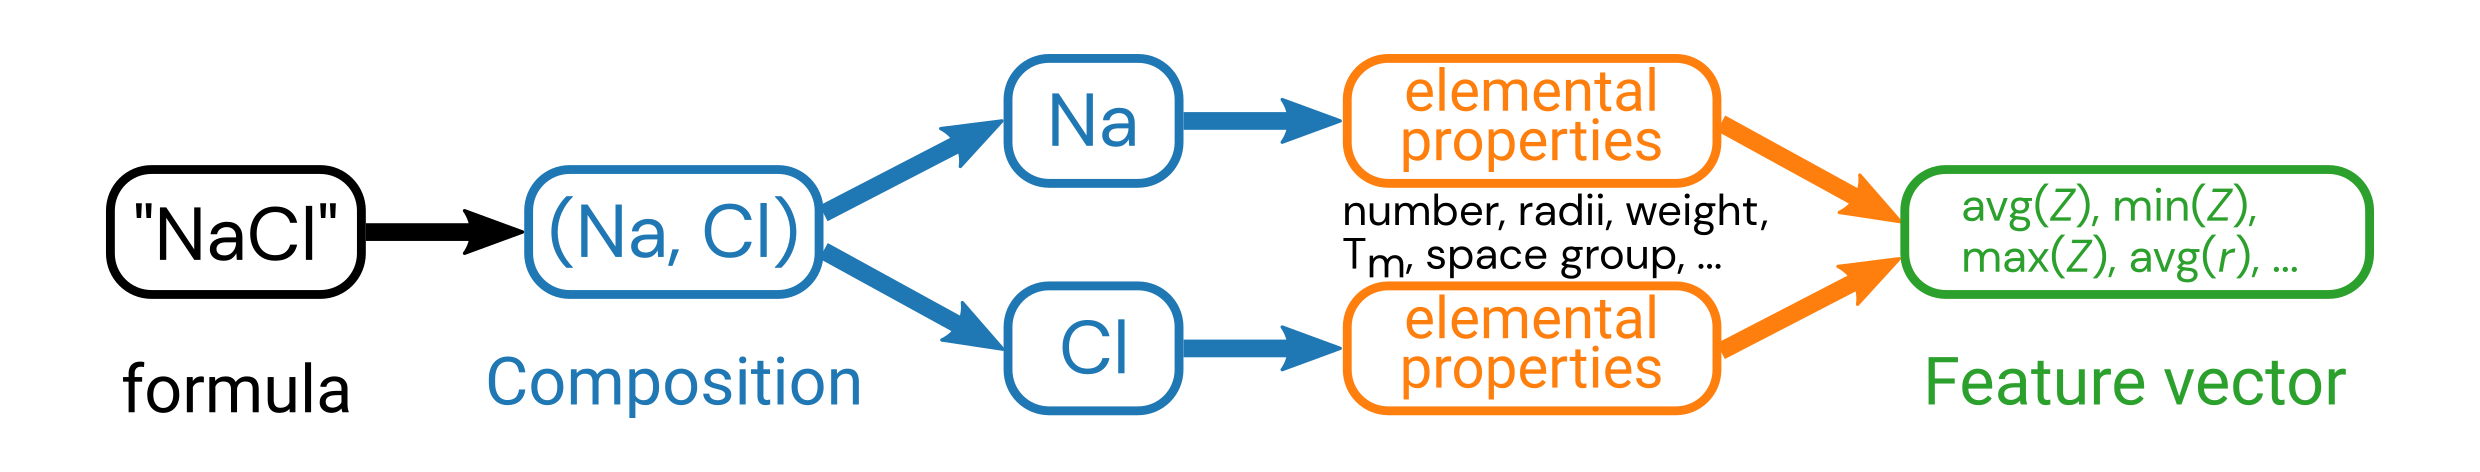

In [55]:
from matminer.featurizers.conversions import StrToComposition

In [56]:
df.columns

Index(['formula', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w',
       'al', 'ti', 'yield strength', 'tensile strength', 'elongation'],
      dtype='object')

In [57]:
df.head()

formula     c    mn    si     cr  \
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...  0.02  0.05  0.05   0.01   
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....  0.18  0.01  0.01  13.44   
2  Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....  0.00  0.01  0.01   8.67   
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...  0.01  0.05  0.05   0.01   
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...  0.01  0.05  0.05   0.01   

      ni    mo     v     n    nb     co     w    al    ti  yield strength  \
0  19.70  2.95  0.01  0.00  0.01  15.00  0.00  0.15  1.55          2411.5   
1   0.01  3.01  0.46  0.04  0.01  19.46  2.35  0.04  0.00          1123.1   
2  13.45  0.82  0.01  0.00  0.01  13.90  0.00  0.39  0.57          1736.3   
3  17.70  3.95  0.01  0.00  0.01  15.00  0.00  0.13  1.47          2487.3   
4  19.40  1.45  0.01  0.00  0.01  14.90  0.00  0.13  1.55          2249.6   

   tensile strength  elongation  
0            2473.5         7.0  
1            1929.2         8.0  
2            1871.8         NaN  
3            2514.9         9.0  
4            2315.0         8.5

In [58]:
# Отбираем только химическую формулу и таргетное свойство
df_form = df[['formula', 'yield strength']]

In [59]:
df_form.head()

formula  yield strength
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...          2411.5
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....          1123.1
2  Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....          1736.3
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...          2487.3
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...          2249.6

In [60]:
# Создаем внутреннюю переменную composition
stc = StrToComposition()

In [61]:
df_form_with_comp = stc.featurize_dataframe(df_form, 'formula')

StrToComposition:   0%|          | 0/312 [00:00<?, ?it/s]

In [62]:
df_form_with_comp.head()

formula  yield strength  \
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...          2411.5   
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....          1123.1   
2  Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....          1736.3   
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...          2487.3   
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...          2249.6   

                                        composition  
0    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)  
1  (Fe, C, Mn, Si, Cr, Ni, Mo, V, N, Nb, Co, W, Al)  
2       (Fe, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)  
3    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)  
4    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)

In [63]:
df_form_with_comp.iloc[0]['composition']

Composition('Fe0.62 C0.000953 Mn0.000521 Si0.00102 Cr0.00011 Ni0.192 Mo0.0176 V0.000112 Nb6.16e-05 Co0.146 Al0.00318 Ti0.0185')

### Рассчитываем элементные признаки
Для описания элементных признаков выберем библиотеку magpie

In [64]:
from matminer.featurizers.composition import ElementProperty

In [65]:
ep = ElementProperty.from_preset('magpie', impute_nan=True)
ep2 = ElementProperty.from_preset('matminer', impute_nan=True)

In [66]:
df_magpie = ep.featurize_dataframe(df_form_with_comp,  ['composition'])
df_matminer = ep2.featurize_dataframe(df_form_with_comp,  ['composition'])

ElementProperty:   0%|          | 0/312 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/312 [00:00<?, ?it/s]

/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:205: UserWarning: No data available for electrical_resistivity for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:205: UserWarning: No data available for electrical_resistivity for He
  warnings.warn(f"No data available for {item} for {self.symbol}")
/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:205: UserWarning: No data available for electrical_resistivity for H
  warnings.warn(f"No data available for {item} for {self.symbol}")
/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:205: UserWarning: No data available for electrical_resistivity for He
  warnings.warn(f"No data available for {item} for {self.symbol}")
/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/pymatgen/core/pe

In [67]:
df_magpie.head()
df_matminer.dropna().head()

formula  yield strength  \
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...          2411.5   
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....          1123.1   
2  Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....          1736.3   
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...          2487.3   
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...          2249.6   

                                        composition  PymatgenData minimum X  \
0    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)                    1.54   
1  (Fe, C, Mn, Si, Cr, Ni, Mo, V, N, Nb, Co, W, Al)                    1.55   
2       (Fe, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)                    1.54   
3    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)                    1.54   
4    (Fe, C, Mn, Si, Cr, Ni, Mo, V, Nb, Co, Al, Ti)                    1.54   

   PymatgenData maximum X  PymatgenData range X  PymatgenData mean X  \
0                    2.55                  1.01             1.852958   
1                    3.04                  1.49             1.831065   
2                    2.16                  0.62             1.828815   
3                    2.55                  1.01             1.853476   
4                    2.55                  1.01             1.849351   

   PymatgenData std_dev X  PymatgenData minimum row  PymatgenData maximum row  \
0                0.097042                         2                         5   
1                0.168785                         2                         6   
2                0.097264                         3                         5   
3                0.099736                         2                         5   
4                0.087293                         2                         5   

   PymatgenData range row  PymatgenData mean row  PymatgenData std_dev row  \
0                       3               4.011555                  0.214164   
1                       4               4.011155                  0.400126   
2                       2               3.996539                  0.152537   
3                       3               4.019028                  0.231078   
4                       3               4.003963                  0.162828   

   PymatgenData minimum group  PymatgenData maximum group  \
0                           4                          14   
1                           5                          15   
2                           4                          14   
3                           4                          14   
4                           4                          14   

   PymatgenData range group  PymatgenData mean group  \
0                        10                 8.447250   
1                        10                 7.896150   
2                        10                 8.207693   
3                        10                 8.396015   
4                        10                 8.450537   

   PymatgenData std_dev group  PymatgenData minimum block  \
0                    1.488293                         2.0   
1                    1.548656                         2.0   
2                    1.525662                         2.0   
3                    1.473536                         2.0   
4                    1.458242                         2.0   

   PymatgenData maximum block  PymatgenData range block  \
0                         3.0                       1.0   
1                         3.0                       1.0   
2                         3.0                       1.0   
3                         3.0                       1.0   
4                         3.0                       1.0   

   PymatgenData mean block  PymatgenData std_dev block  \
0                 2.994847                    0.095950   
1                 2.988780                    0.141476   
2                 2.991677                    0.120741   
3                 2.995729                    0.088304   
4                 2.995776      

In [68]:
df_magpie = df_magpie.drop(['formula', 'composition'], axis=1)
df_matminer = df_matminer.drop(['formula', 'composition'], axis=1)

In [69]:
df_magpie.shape, df_matminer.shape

((312, 133), (312, 66))

In [70]:
df_magpie.head()

yield strength  MagpieData minimum Number  MagpieData maximum Number  \
0          2411.5                        6.0                       42.0   
1          1123.1                        6.0                       74.0   
2          1736.3                       13.0                       42.0   
3          2487.3                        6.0                       42.0   
4          2249.6                        6.0                       42.0   

   MagpieData range Number  MagpieData mean Number  MagpieData avg_dev Number  \
0                     36.0               26.664769                   1.152116   
1                     68.0               26.300744                   1.522817   
2                     29.0               26.145400                   0.858372   
3                     36.0               26.743298                   1.235479   
4                     36.0               26.526613                   0.958219   

   MagpieData mode Number  MagpieData minimum MendeleevNumber  \
0                    26.0                                43.0   
1                    26.0                                46.0   
2                    26.0                                43.0   
3                    26.0                                43.0   
4                    26.0                                43.0   

   MagpieData maximum MendeleevNumber  MagpieData range MendeleevNumber  \
0                                78.0                              35.0   
1                                82.0                              36.0   
2                                78.0                              35.0   
3                                78.0                              35.0   
4                                78.0                              35.0   

   MagpieData mean MendeleevNumber  MagpieData avg_dev MendeleevNumber  \
0                        56.377863                            2.437556   
1                        54.768497                            2.013802   
2                        55.653308                            2.290349   
3                        56.227153                            2.327724   
4                        56.375439                            2.360988   

   MagpieData mode MendeleevNumber  MagpieData minimum AtomicWeight  \
0                             55.0                        12.010700   
1                             55.0                        12.010700   
2                             55.0                        26.981539   
3                             55.0                        12.010700   
4                             55.0                        12.010700   

   MagpieData maximum AtomicWeight  MagpieData range AtomicWeight  \
0                            95.96                      83.949300   
1                           183.84                     171.829300   
2                            95.96                      68.978461   
3                            95.96                      83.949300   
4                            95.96                      83.949300   

   MagpieData mean AtomicWeight  MagpieData avg_dev AtomicWeight  \
0                     57.240083                         2.419658   
1                     57.015783                         3.969693   
2                     56.160791                         1.772402   
3                     57.471595                         2.679939   
4                     56.896297                         1.938594   

   MagpieData mode AtomicWeight  MagpieData minimum MeltingT  \
0                        55.845                       933.47   
1                        55.845                        63.05   
2                        55.845                       933.47   
3                        55.845                       933.47   
4                        55.845                       933.47   

   MagpieData maximum MeltingT  MagpieData range MeltingT  \
0                       3823.0                    2889.53   
1                   

In [71]:
df_magpie = df_magpie.loc[:, (df_magpie != 0).any(axis=0)] #убираем нули
df_magpie.dropna(axis=1, inplace=True) #убираем NaN
df_magpie = df_magpie.loc[:, (df_magpie != df_magpie.iloc[0]).any()] #убираем константы

In [72]:
df_magpie.shape

(312, 81)

In [73]:
df_magpie.corr()

yield strength  \
yield strength                              1.000000   
MagpieData minimum Number                   0.040847   
MagpieData maximum Number                   0.026570   
MagpieData range Number                     0.014979   
MagpieData mean Number                      0.260439   
MagpieData avg_dev Number                   0.019008   
MagpieData minimum MendeleevNumber         -0.100362   
MagpieData maximum MendeleevNumber         -0.150624   
MagpieData range MendeleevNumber           -0.038512   
MagpieData mean MendeleevNumber             0.314482   
MagpieData avg_dev MendeleevNumber          0.170413   
MagpieData minimum AtomicWeight             0.040866   
MagpieData maximum AtomicWeight             0.026570   
MagpieData range AtomicWeight               0.017564   
MagpieData mean AtomicWeight                0.234489   
MagpieData avg_dev AtomicWeight             0.013133   
MagpieData minimum MeltingT                 0.150624   
MagpieData maximum MeltingT                -0.028854   
MagpieData range MeltingT                  -0.128706   
MagpieData mean MeltingT                   -0.203105   
MagpieData avg_dev MeltingT                -0.199165   
MagpieData minimum Column                  -0.100362   
MagpieData maximum Column                  -0.150624   
MagpieData range Column                    -0.005517   
MagpieData mean Column                      0.328039   
MagpieData avg_dev Column                   0.215190   
MagpieData minimum Row                      0.041108   
MagpieData maximum Row                      0.026570   
MagpieData range Row                       -0.015041   
MagpieData mean Row                         0.053058   
MagpieData avg_dev Row                     -0.034926   
MagpieData minimum CovalentRadius           0.065977   
MagpieData maximum CovalentRadius          -0.048448   
MagpieData range CovalentRadius            -0.066794   
MagpieData mean CovalentRadius             -0.311635   
MagpieData avg_dev CovalentRadius           0.356422   
MagpieData minimum Electronegativity       -0.107594   
MagpieData maximum Electronegativity       -0.139639   
MagpieData range Electronegativity         -0.138572   
MagpieData mean Electronegativity           0.421446   
MagpieData avg_dev Electronegativity       -0.081593   
MagpieData mean NsValence                   0.390856   
MagpieData avg_dev NsValence               -0.396742   
MagpieData maximum NpValence               -0.150624   
MagpieData range NpValence                 -0.150624   
MagpieData mean NpValence                  -0.084765   
MagpieData avg_dev NpValence               -0.087704   
MagpieData mean NdValence                   0.321324   
MagpieData avg_dev NdValence                0.384671   
MagpieData maximum NfValence                0.026570   
MagpieData range NfValence                  0.026570   
MagpieData mean NfValence                  -0.025863   
MagpieData avg_dev NfValence               -0.025915   
MagpieData maximum NValence                 0.026570   
MagpieData range NValence                   0.026570   
MagpieData mean NValence                    0.351650   
MagpieData avg_dev NValence                 0.136991   
MagpieData mean NsUnfilled                 -0.390856   
MagpieData avg_dev NsUnfilled              -0.396742   
MagpieData mean NpUnfilled                 -0.088229   
MagpieData avg_dev NpUnfilled              -0.091153   
MagpieData maximum NdUnfilled               0.100362   
MagpieData range NdUnfilled                 0.100362   
MagpieData mean NdUnfilled                 -0.308229   
MagpieData avg_dev NdUnfilled               0.340054   
MagpieData maximum NUnfilled                0.100362   
MagpieData range NUnfilled                  0.100362   
MagpieData mean NUnfilled                  -0.359027   
MagpieData avg_dev NUnfilled                0.262989   
MagpieData minimum GSvolume_pa              0.038568   
MagpieData range GSvolume_pa               -0.038568   
Magpie

<Axes: >

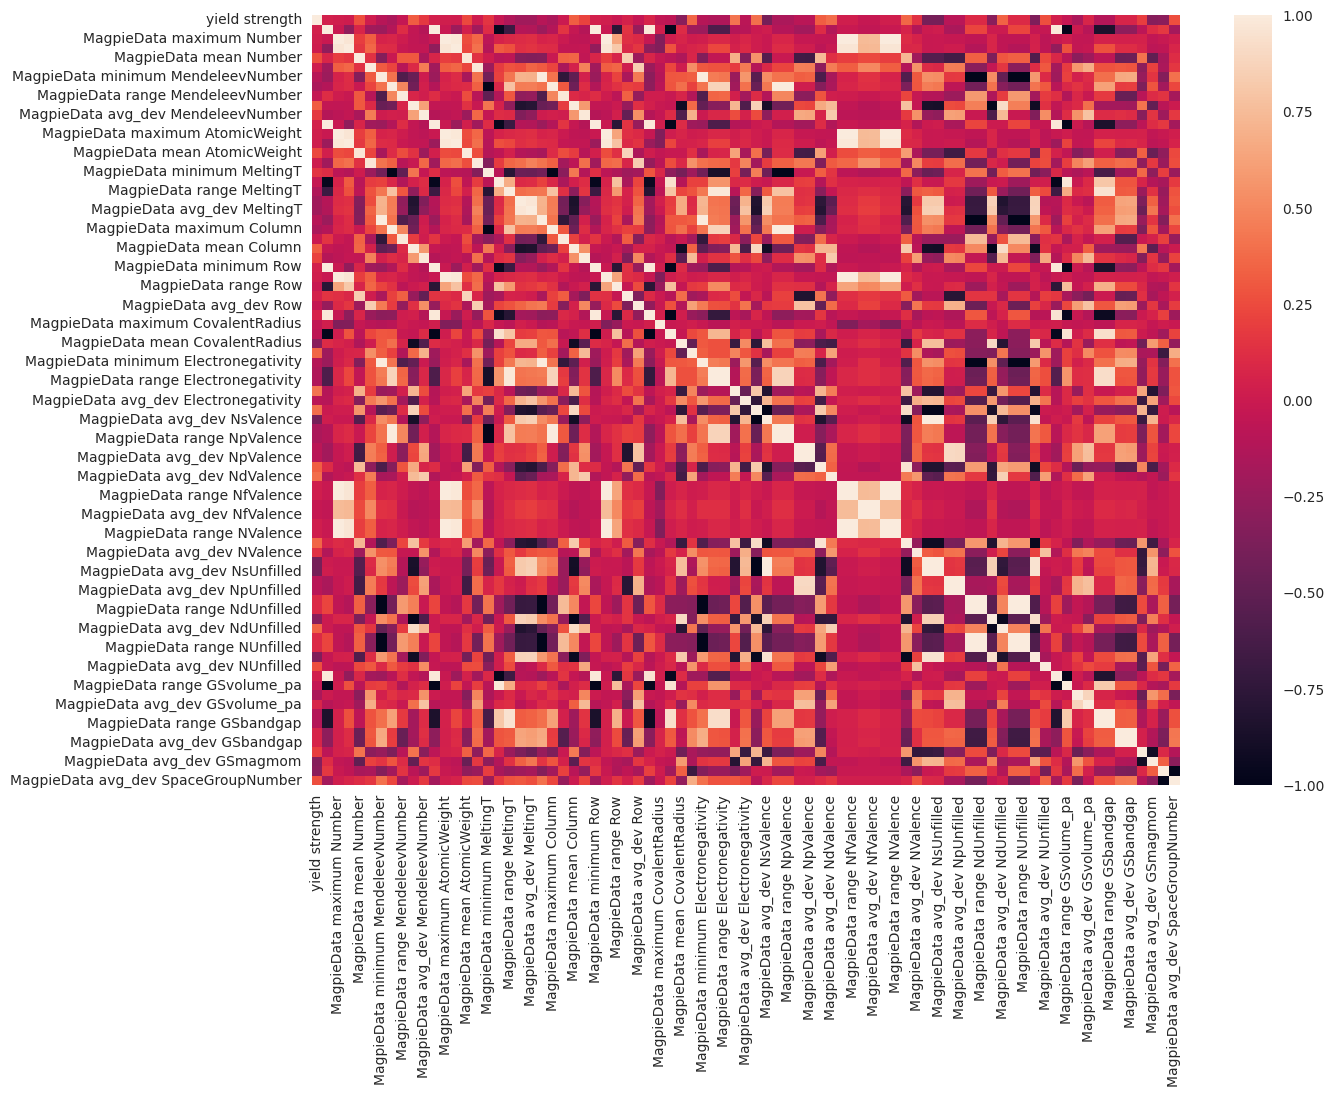

In [74]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(df_magpie.corr())

In [75]:
df_magpie.columns

Index(['yield strength', 'MagpieData minimum Number',
       'MagpieData maximum Number', 'MagpieData range Number',
       'MagpieData mean Number', 'MagpieData avg_dev Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       'MagpieData avg_dev MendeleevNumber', 'MagpieData minimum AtomicWeight',
       'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight',
       'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight',
       'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT',
       'MagpieData range MeltingT', 'MagpieData mean MeltingT',
       'MagpieData avg_dev MeltingT', 'MagpieData minimum Column',
       'MagpieData maximum Column', 'MagpieData range Column',
       'MagpieData mean Column', 'MagpieData avg_dev Column',
       'MagpieData minimum Row', 'MagpieData maximum Row',
       'MagpieData range Row', 'MagpieDa

# Домашнее задание

### Обучение модели линейной регрессии для элементных признаков и расчет ошибки

In [76]:
plt.style.use('seaborn-v0_8')
# plt.rcParams['font.size'] = 16

In [79]:

def show_score(model, X_train, X_test, y_train, y_test, title):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.title(title)
    plt.plot(y_train, y_train, '--k')
    plt.scatter(y_train, y_pred_train, label='train')
    plt.scatter(y_test, y_pred_test, label='test')

    plt.ylabel('True values')
    plt.xlabel('Predictions')
    plt.legend(fontsize=20);

    print("RMSE train:", mse(y_train, y_pred_train) ** 0.5)
    print("RMSE test:", mse(y_test, y_pred_test) ** 0.5)
    print("R2 score train:", r2_score(y_train, y_pred_train))
    print("R2 score test:", r2_score(y_test, y_pred_test))

RMSE train: 164.16601856646972
RMSE test: 391037529110099.5


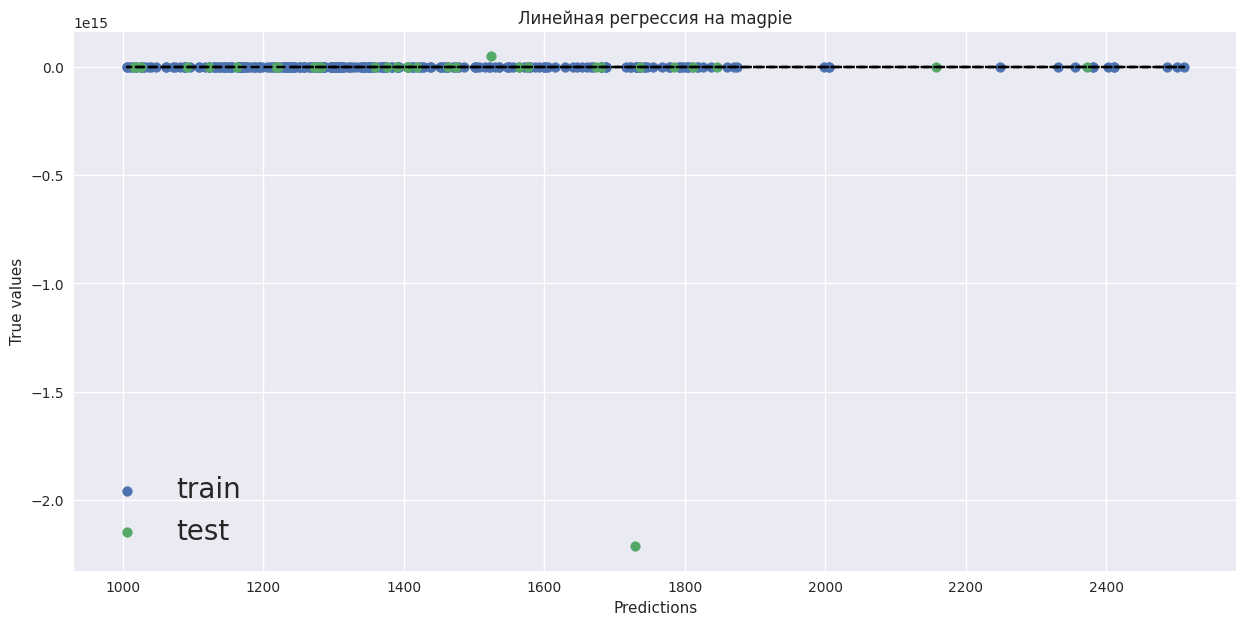

In [78]:
# разбивка данных на обучающую и тестовые выборки 



X = df_magpie.drop('yield strength', axis=1)
Y = df_magpie['yield strength']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)

show_score(lr, X_train, X_test, y_train, y_test, title='Линейная регрессия на magpie')

Как можно заметить, есть определенный выброс, который мешает обучаться модели

<Axes: xlabel='yield strength', ylabel='Count'>

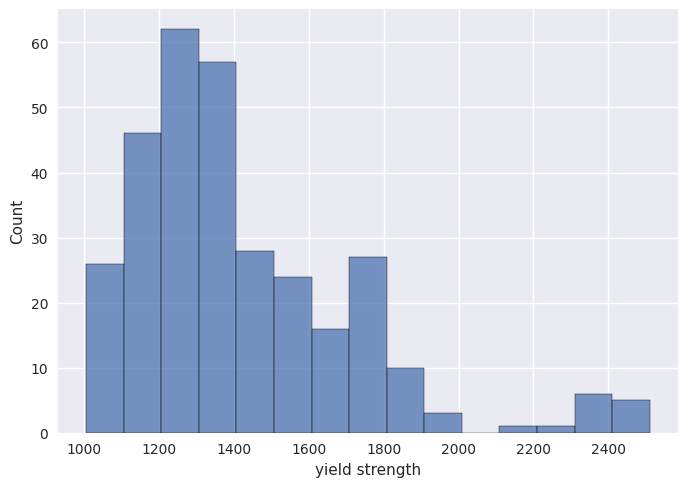

In [125]:
sns.histplot(Y)

Значит, выброс где-то в X

RMSE train: 160.82197670211795
RMSE test: 276.02048322378346


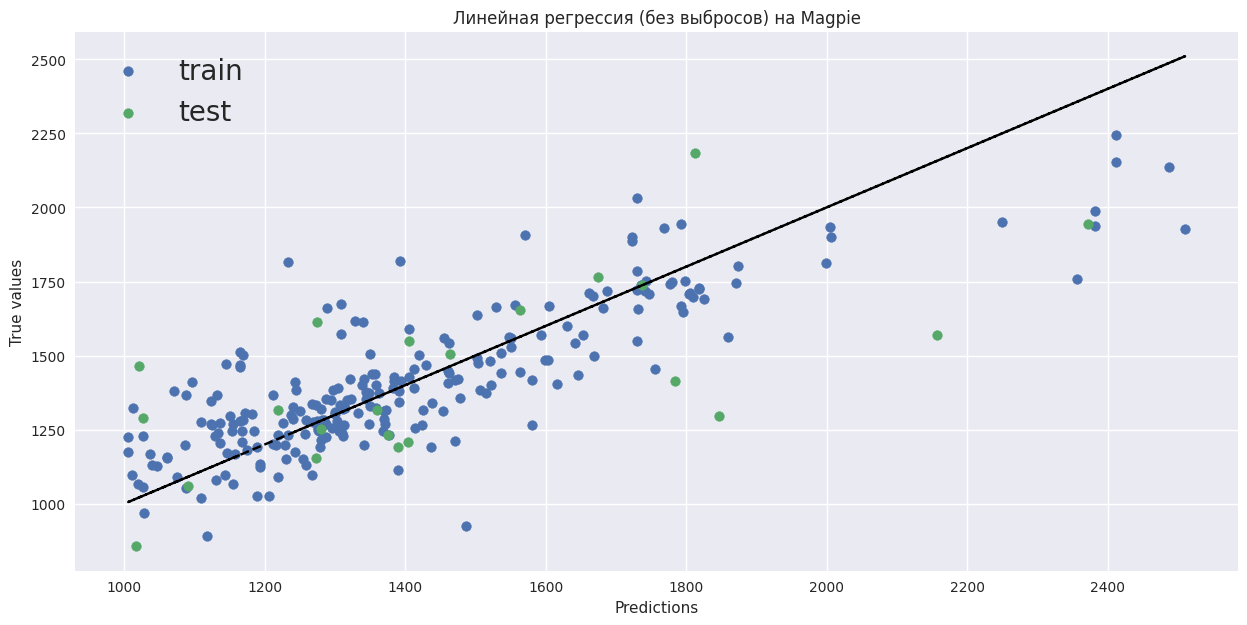

In [61]:
threshold = 3

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train[(np.abs(X_train) < threshold).all(axis=1)]
X_train = X_train[(np.abs(X_train) < threshold).all(axis=1)]

y_test = y_test[(np.abs(X_test) < threshold).all(axis=1)]
X_test = X_test[(np.abs(X_test) < threshold).all(axis=1)]

lr = LinearRegression()
lr.fit(X_train, y_train)

show_score(lr, X_train, X_test, y_train, y_test, 'Линейная регрессия (без выбросов) на Magpie')



In [62]:
cross_validate(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

{'fit_time': array([0.0226059 , 0.18463016, 0.03144002, 0.00634456, 0.00304627]),
 'score_time': array([0.00112176, 0.00097036, 0.00104594, 0.00071764, 0.00055456]),
 'test_score': array([-198.1115013 , -202.25648194, -249.11651087, -221.06501568,
        -247.32039943])}

### Обучение модели catboost для элементных признаков и расчет ошибки

RMSE train: 13.72120488659781
RMSE test: 183.88584943474845


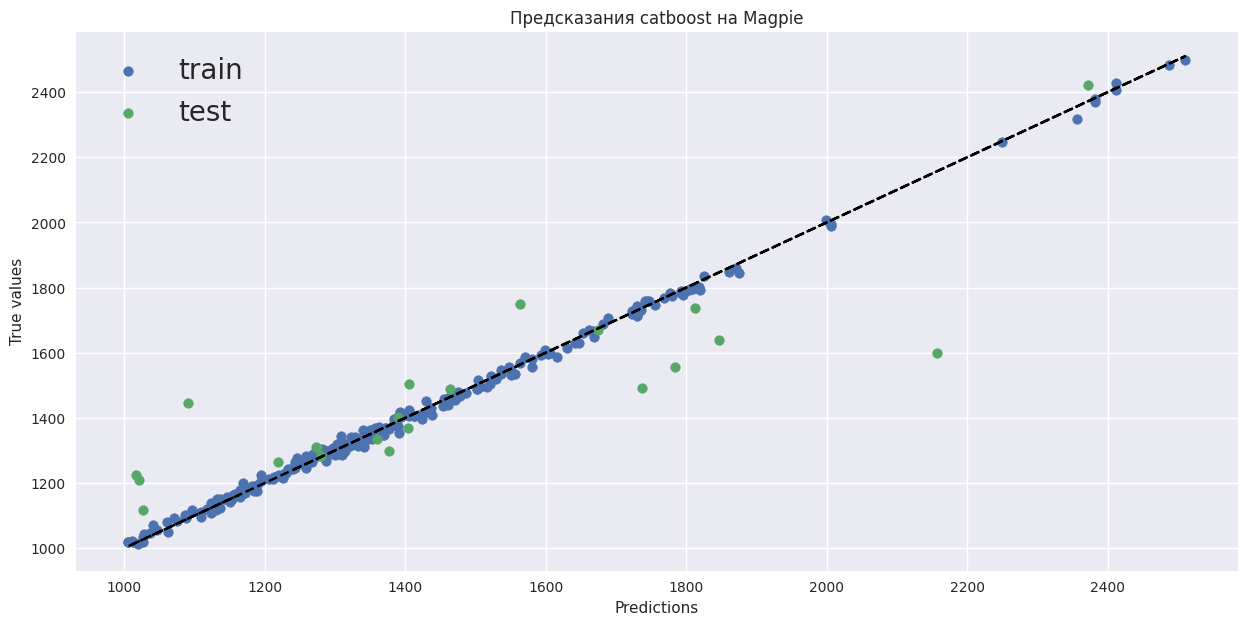

In [63]:
cat_boost = CatBoostRegressor()
cat_boost.fit(X_train, y_train, verbose=0)
show_score(cat_boost, X_train, X_test, y_train, y_test, 'Предсказания catboost на Magpie')

Градиентный бустинг способен легко переобучаться, поэтому на трейне намного ниже ошибка

In [64]:
cross_validate(cat_boost, X_train, y_train, cv=5, verbose=0, scoring='neg_root_mean_squared_error')

Learning rate set to 0.03152
0:	learn: 284.5228352	total: 22.3ms	remaining: 22.3s
1:	learn: 281.0096501	total: 27.6ms	remaining: 13.8s
2:	learn: 277.7012769	total: 34.1ms	remaining: 11.3s
3:	learn: 274.3703914	total: 38.7ms	remaining: 9.64s
4:	learn: 271.5735139	total: 42.2ms	remaining: 8.39s
5:	learn: 267.9518989	total: 47ms	remaining: 7.79s
6:	learn: 264.3384999	total: 51.4ms	remaining: 7.29s
7:	learn: 262.1682517	total: 55.5ms	remaining: 6.88s
8:	learn: 259.1069657	total: 58.4ms	remaining: 6.43s
9:	learn: 255.9726768	total: 62.3ms	remaining: 6.17s
10:	learn: 253.1974198	total: 65.9ms	remaining: 5.92s
11:	learn: 250.4383544	total: 68.5ms	remaining: 5.63s
12:	learn: 248.1140528	total: 71.9ms	remaining: 5.46s
13:	learn: 245.6080951	total: 74.6ms	remaining: 5.25s
14:	learn: 242.7835780	total: 76.9ms	remaining: 5.05s
15:	learn: 240.8046808	total: 80.8ms	remaining: 4.97s
16:	learn: 237.9252042	total: 83.2ms	remaining: 4.81s
17:	learn: 235.1788285	total: 85.1ms	remaining: 4.64s
18:	learn: 

{'fit_time': array([2.55197287, 2.70230222, 2.62777805, 2.4141748 , 2.60785031]),
 'score_time': array([0.00887823, 0.0052433 , 0.00670648, 0.00542259, 0.01239681]),
 'test_score': array([-145.60477736, -114.48044174, -156.83303428, -152.59723892,
        -222.55598685])}

1.  ~~Рассчитать score на кросс-валидации для моделей LinearRegression и CatBoost~~
2.  Обучить нейронную сеть (MLPRegressor) и подобрать оптимальные гиперпараметры

### MLPRegressor

RMSE train: 96.19696079423976
RMSE test: 128.34759588217165


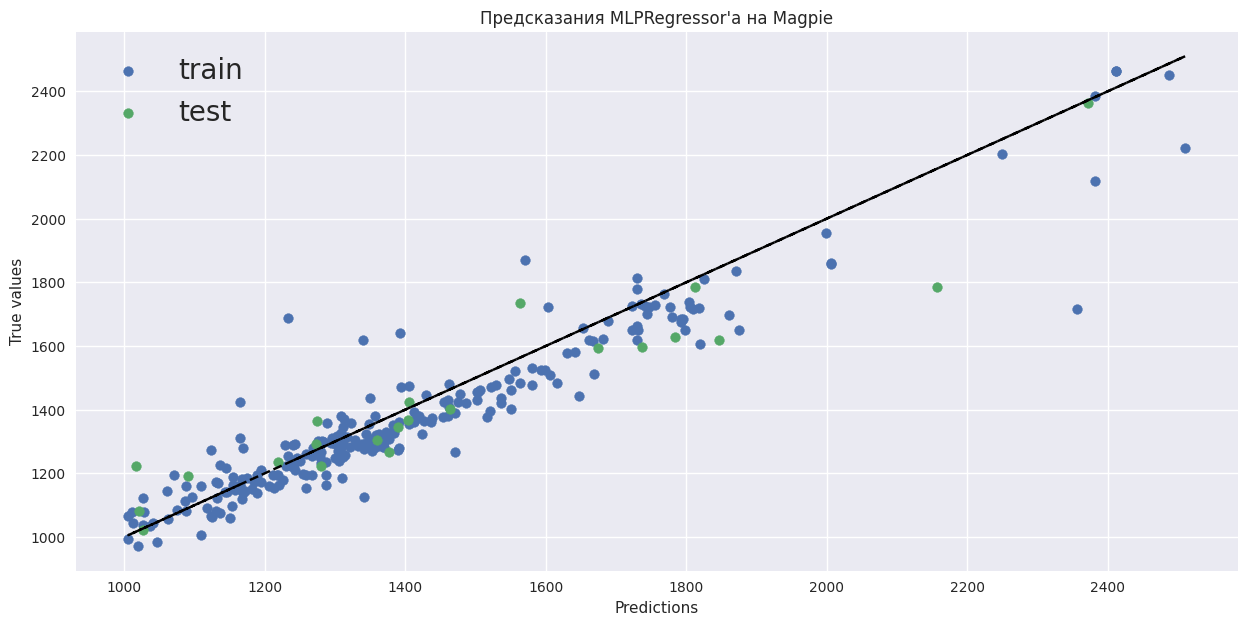

In [65]:
mlr = MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 
                                       64, 64, 64, 64, 64 ,64, 64, 64, 64, 64, 
                                       64 ,64, 64, 64, 64 ,64, 64, 64, 64, 64,), # А говорят, что если много слоев, то градиент будет затухать
                   max_iter=1000)
mlr.fit(X_train, y_train)

show_score(mlr, X_train, X_test, y_train, y_test, 'Предсказания MLPRegressor\'a на Magpie')

In [167]:
cross_validate(mlr, X_train, y_train, cv=5, verbose=0, scoring='neg_root_mean_squared_error')

{'fit_time': array([7.18020964, 5.56070209, 5.65723443, 4.56541586, 9.85554862]),
 'score_time': array([0.00146294, 0.00160885, 0.00174809, 0.00270963, 0.00177455]),
 'test_score': array([-156.49573934, -135.94783337, -291.85862721, -156.15649642,
        -193.26657462])}

Наилучший score на тестовых данных оказался у MLPRegressor'a. Объяснить это можно тем, что линейная регрессия не смогла предсказывать какие-то более сложные, чем линейные зависимости, а CatBoost несколько переобучился. Вероятно, с другими гиперпараметрами градиентный бустинг мог дать и результат получше.

2.  ~~Обучить нейронную сеть (MLPRegressor)~~    
            и ?  ~~подобрать оптимальные гиперпараметры~~
3. ~~Сравнить полученные score разных алгоритмов~~


4.  Придумать новые признаки модели, которые будут давать меньшую ошибку на кросс-валидации

Вряд ли можно подобрать что-то сильно улучшающее модель по элементным признакам (если только добавить концентрации), поэтому я осознаю, что это задание было, вероятно, для прошлого датасета с исходным составом.

In [49]:

atomic_masses = {
    'c': 12.01, 'mn': 54.94, 'si': 28.09, 'cr': 51.996, 'ni': 58.69,
    'mo': 95.95, 'v': 50.94, 'n': 14.01, 'nb': 92.91, 'co': 58.93,
    'w': 183.84, 'al': 26.98, 'ti': 47.87
}


electronegativities = {
    'c': 2.55, 'mn': 1.55, 'si': 1.90, 'cr': 1.66, 'ni': 1.91,
    'mo': 2.16, 'v': 1.63, 'n': 3.04, 'nb': 1.6, 'co': 1.88,
    'w': 2.36, 'al': 1.61, 'ti': 1.54
}


df['mean_atomic_mass'] = sum(df[elem] * atomic_masses[elem] * 0.01 for elem in atomic_masses)
df['range_electronegativity'] = df[list(electronegativities.keys())].apply(
    lambda row: max(row.values) - min(row.values), axis=1)

df = df.dropna()
df.head()

formula     c    mn    si     cr  \
0  Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...  0.02  0.05  0.05   0.01   
1  Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....  0.18  0.01  0.01  13.44   
3  Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...  0.01  0.05  0.05   0.01   
4  Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...  0.01  0.05  0.05   0.01   
5  Fe0.636C0.00881Mn0.000203Si0.00972Cr0.135Ni0.0...  0.19  0.02  0.49  12.56   

      ni    mo     v     n    nb     co     w    al    ti  yield strength  \
0  19.70  2.95  0.01  0.00  0.01  15.00  0.00  0.15  1.55          2411.5   
1   0.01  3.01  0.46  0.04  0.01  19.46  2.35  0.04  0.00          1123.1   
3  17.70  3.95  0.01  0.00  0.01  15.00  0.00  0.13  1.47          2487.3   
4  19.40  1.45  0.01  0.00  0.01  14.90  0.00  0.13  1.55          2249.6   
5   0.94  1.96  0.01  0.00  0.01  20.10  0.00  0.03  0.00          1328.3   

   tensile strength  elongation  mean_atomic_mass  range_electronegativity  
0            2473.5         7.0         24.077912                    19.70  
1            1929.2         8.0         25.960176                    19.46  
3            2514.9         9.0         23.818719                    17.70  
4            2315.0         8.5         22.397065                    19.40  
5            1779.5        19.7         21.001861                    20.10

RMSE train: 73.8502308701017
RMSE test: 107.33544706263856


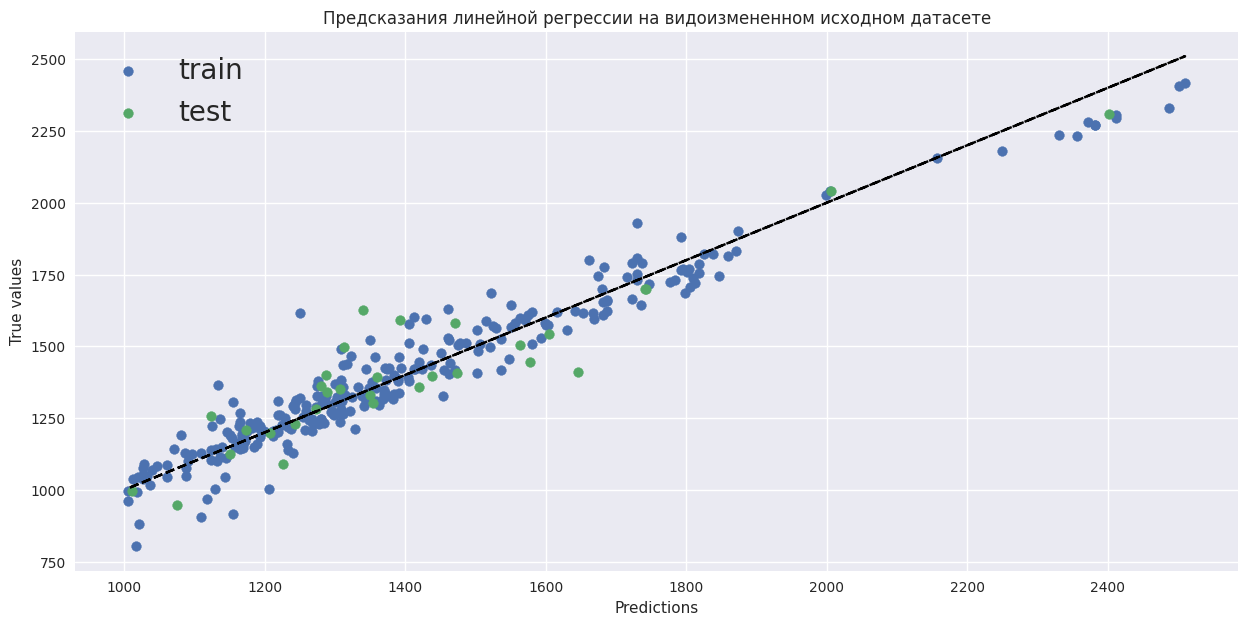

In [66]:
X = df.drop(['yield strength', 'formula'], axis=1)
Y = df['yield strength']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)

show_score(lr, X_train, X_test, y_train, y_test, 'Предсказания линейной регрессии на видоизмененном исходном датасете')

In [55]:
cross_validate(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

{'fit_time': array([0.00280643, 0.00095439, 0.00098825, 0.00078583, 0.00090361]),
 'score_time': array([0.00137115, 0.00057268, 0.00045943, 0.00047302, 0.00043273]),
 'test_score': array([ -88.08732191,  -82.36612114,  -79.83296568, -104.91372705,
         -57.16153218])}

Окей, то есть тут она сработала даже лучше, чем magpie версия. Вероятно, это потому, что линейная регрессия очень чувствительна к корелляциям в данных, а в датасете от magpie их очень много. Либо, быть может есть какие-то очень прямые зависимости по какому-то конкретному элементу, а в magpie, кажется, концентрации уже не используются.

RMSE train: 9.312337456788535
RMSE test: 103.2460771772623


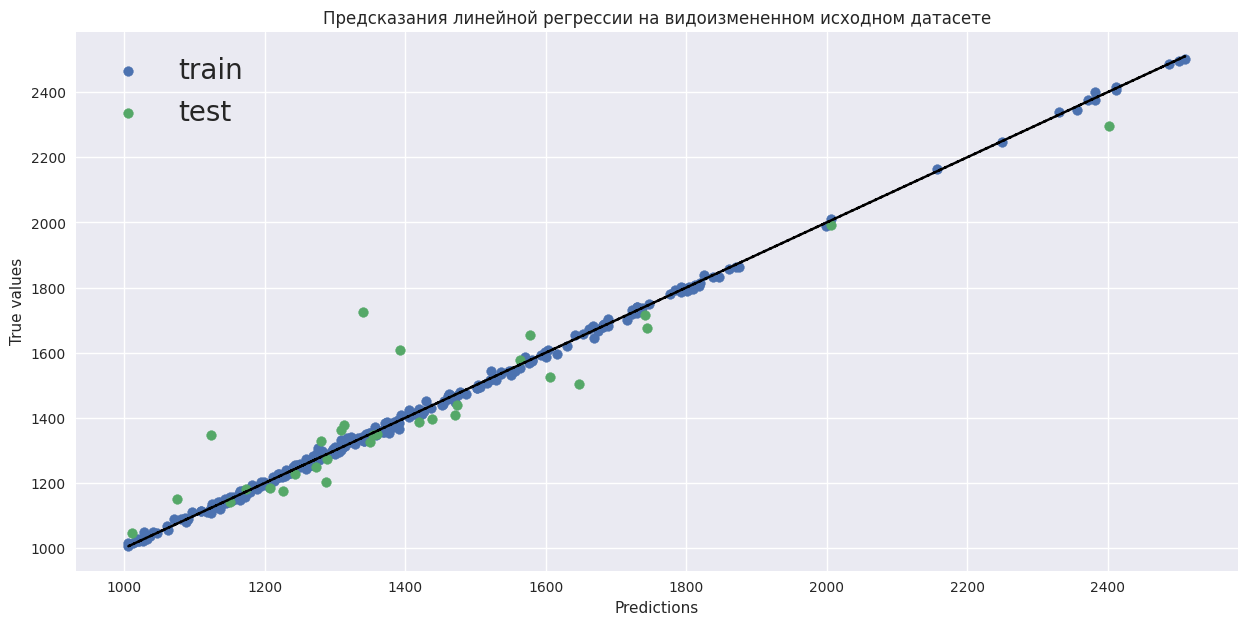

In [72]:
cat_boost = CatBoostRegressor()
cat_boost.fit(X_train, y_train, verbose=0)

show_score(cat_boost, X_train, X_test, y_train, y_test, 'Предсказания линейной регрессии на видоизмененном исходном датасете')

In [76]:
from IPython.display import clear_output
output = cross_validate(cat_boost, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
clear_output()
output

{'fit_time': array([0.92381763, 0.78275371, 0.7227416 , 0.83656883, 0.82101655]),
 'score_time': array([0.00369239, 0.00253415, 0.00255203, 0.00433183, 0.00379777]),
 'test_score': array([-88.9017461 , -58.43358352, -61.57179434, -81.07756274,
        -61.04897599])}

### Задание:

1. Подобрать оптимальный набор элементных признаков и алгоритм машинного обучения (тот, который будет давать минимальную ошибку) для базы данных сталей steels_kaggle.
2. Визуализировать датасет с помощью метода сокращения размерности (PCA, t-SNE, UMAP). Сделать кластеризацию и отобразить различные кластеры. (не обязательно, если есть желание)

In [5]:
df2 = pd.read_csv('Databases/Steels_kaggle.csv')

In [6]:
df2.shape

(915, 20)

In [7]:
df2.head(20)

Alloy code     C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V  \
0         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
1         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
2         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
3         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
4         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
5         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
6         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
7         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
8         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
9         MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
10        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
11        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
12        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
13        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
14        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
15        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
16        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
17        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
18        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   
19        MBC  0.09  0.37  0.49  0.006  0.005  0.055  0.98  0.57  0.07  0.0   

       Al       N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0   0.003  0.0066  0.0      0.0                 27                       342   
1   0.003  0.0066  0.0      0.0                100                       338   
2   0.003  0.0066  0.0      0.0                200                       337   
3   0.003  0.0066  0.0      0.0                300                       346   
4   0.003  0.0066  0.0      0.0                400                       316   
5   0.003  0.0066  0.0      0.0                450                       287   
6   0.003  0.0066  0.0      0.0                500                       274   
7   0.003  0.0066  0.0      0.0                550                       262   
8   0.003  0.0066  0.0      0.0                600                       220   
9   0.003  0.0066  0.0      0.0                650                       152   
10  0.005  0.0080  0.0      0.0                 27                       310   
11  0.005  0.0080  0.0      0.0                100                       285   
12  0.005  0.0080  0.0      0.0                200                       296   
13  0.005  0.0080  0.0      0.0                300                       265   
14  0.005  0.0080  0.0      0.0                400                       257   
15  0.005  0.0080  0.0      0.0                450                       240   
16  0.005  0.0080  0.0      0.0                500                       232   
17  0.005  0.0080  0.0      0.0                550                       207   
18  0.005  0.0080  0.0      0.0                600                       176   
19  0.005  0.0080  0.0      0.0                650                       132   

     Tensile Strength (MPa)   Elongation (%)   Reduction in Area (%)  
0                       490               30                      71  
1                       454               27                      72  
2                       465               23                      69  
3                       495               21                      70  
4                       489               26                      79  
5                       461               25                      81  
6                       431               28                      85  
7                       387               32                      87  
8                      

In [8]:
df2.columns

Index(['Alloy code', ' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo',
       ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)',
       ' 0.2% Proof Stress (MPa)', ' Tensile Strength (MPa)',
       ' Elongation (%)', ' Reduction in Area (%)'],
      dtype='object')

In [9]:
formulas = pd.Series(['']* len(df2), name='formula')
antiFe = pd.Series([0] * len(df2), name='formula')
for el in df2.columns[1:13]:
    formulas += el + (df2[el] * 0.01).apply(lambda x: f"{x:.6f}")
    antiFe += df2[el] * 0.01

formulas = ((1 - antiFe).apply(lambda x: f"Fe{x:.6f}") + formulas).apply(lambda x: x.replace(' ', ''))
formulas[:10]

0    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
1    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
2    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
3    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
4    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
5    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
6    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
7    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
8    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
9    Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...
Name: formula, dtype: object

In [80]:
df_form = pd.DataFrame({'formula': formulas, ' 0.2% Proof Stress (MPa)': df2[' 0.2% Proof Stress (MPa)']})
df_form.head(3)

formula   0.2% Proof Stress (MPa)
0  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...                       342
1  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...                       338
2  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...                       337

In [81]:
from matminer.featurizers.conversions import StrToComposition
stc = StrToComposition()
df_form_with_comp = stc.featurize_dataframe(df_form, 'formula')
df_form_with_comp.head()

StrToComposition:   0%|          | 0/915 [00:00<?, ?it/s]

formula  \
0  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
1  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
2  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
3  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
4  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   

    0.2% Proof Stress (MPa)                                   composition  
0                       342  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)  
1                       338  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)  
2                       337  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)  
3                       346  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)  
4                       316  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)

In [82]:
from matminer.featurizers.composition import ElementProperty
ep = ElementProperty.from_preset('magpie', impute_nan=True)
df_magpie = ep.featurize_dataframe(df_form_with_comp,  ['composition'])
df_magpie.head()

ElementProperty:   0%|          | 0/915 [00:00<?, ?it/s]

formula  \
0  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
1  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
2  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
3  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   
4  Fe0.972694C0.001200Si0.003600Mn0.005200P0.0000...   

    0.2% Proof Stress (MPa)                                   composition  \
0                       342  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)   
1                       338  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)   
2                       337  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)   
3                       346  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)   
4                       316  (Fe, C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)   

   MagpieData minimum Number  MagpieData maximum Number  \
0                        6.0                       42.0   
1                        6.0                       42.0   
2                        6.0                       42.0   
3                        6.0                       42.0   
4                        6.0                       42.0   

   MagpieData range Number  MagpieData mean Number  MagpieData avg_dev Number  \
0                     36.0               26.005846                   0.201074   
1                     36.0               26.005846                   0.201074   
2                     36.0               26.005846                   0.201074   
3                     36.0               26.005846                   0.201074   
4                     36.0               26.005846                   0.201074   

   MagpieData mode Number  MagpieData minimum MendeleevNumber  \
0                    26.0                                49.0   
1                    26.0                                49.0   
2                    26.0                                49.0   
3                    26.0                                49.0   
4                    26.0                                49.0   

   MagpieData maximum MendeleevNumber  MagpieData range MendeleevNumber  \
0                                88.0                              39.0   
1                                88.0                              39.0   
2                                88.0                              39.0   
3                                88.0                              39.0   
4                                88.0                              39.0   

   MagpieData mean MendeleevNumber  MagpieData avg_dev MendeleevNumber  \
0                        55.019672                            0.247696   
1                        55.019672                            0.247696   
2                        55.019672                            0.247696   
3                        55.019672                            0.247696   
4                        55.019672                            0.247696   

   MagpieData mode MendeleevNumber  MagpieData minimum AtomicWeight  \
0                             55.0                          12.0107   
1                             55.0                          12.0107   
2                             55.0                          12.0107   
3                             55.0                          12.0107   
4                             55.0                          12.0107   

   MagpieData maximum AtomicWeight  MagpieData range AtomicWeight  \
0                            95.96                        83.9493   
1                            95.96                        83.9493   
2                            95.96                        83.9493   
3                            95.96                        83.9493   
4                            95.96                        83.9493   

   MagpieData mean AtomicWeight  MagpieData avg_dev AtomicWeight  \
0                     55.894152                         0.499907   
1                     55.894152                         0.499907   
2                     55.894152                         0.499907   
3 

In [83]:
df_magpie = df_magpie.drop(['formula', 'composition'], axis=1)
df_magpie = df_magpie.loc[:, (df_magpie != 0).any(axis=0)] #убираем нули
df_magpie.dropna(axis=1, inplace=True) #убираем NaN
df_magpie = df_magpie.loc[:, (df_magpie != df_magpie.iloc[0]).any()] #убираем константы
df_magpie.shape

(915, 54)

<Axes: >

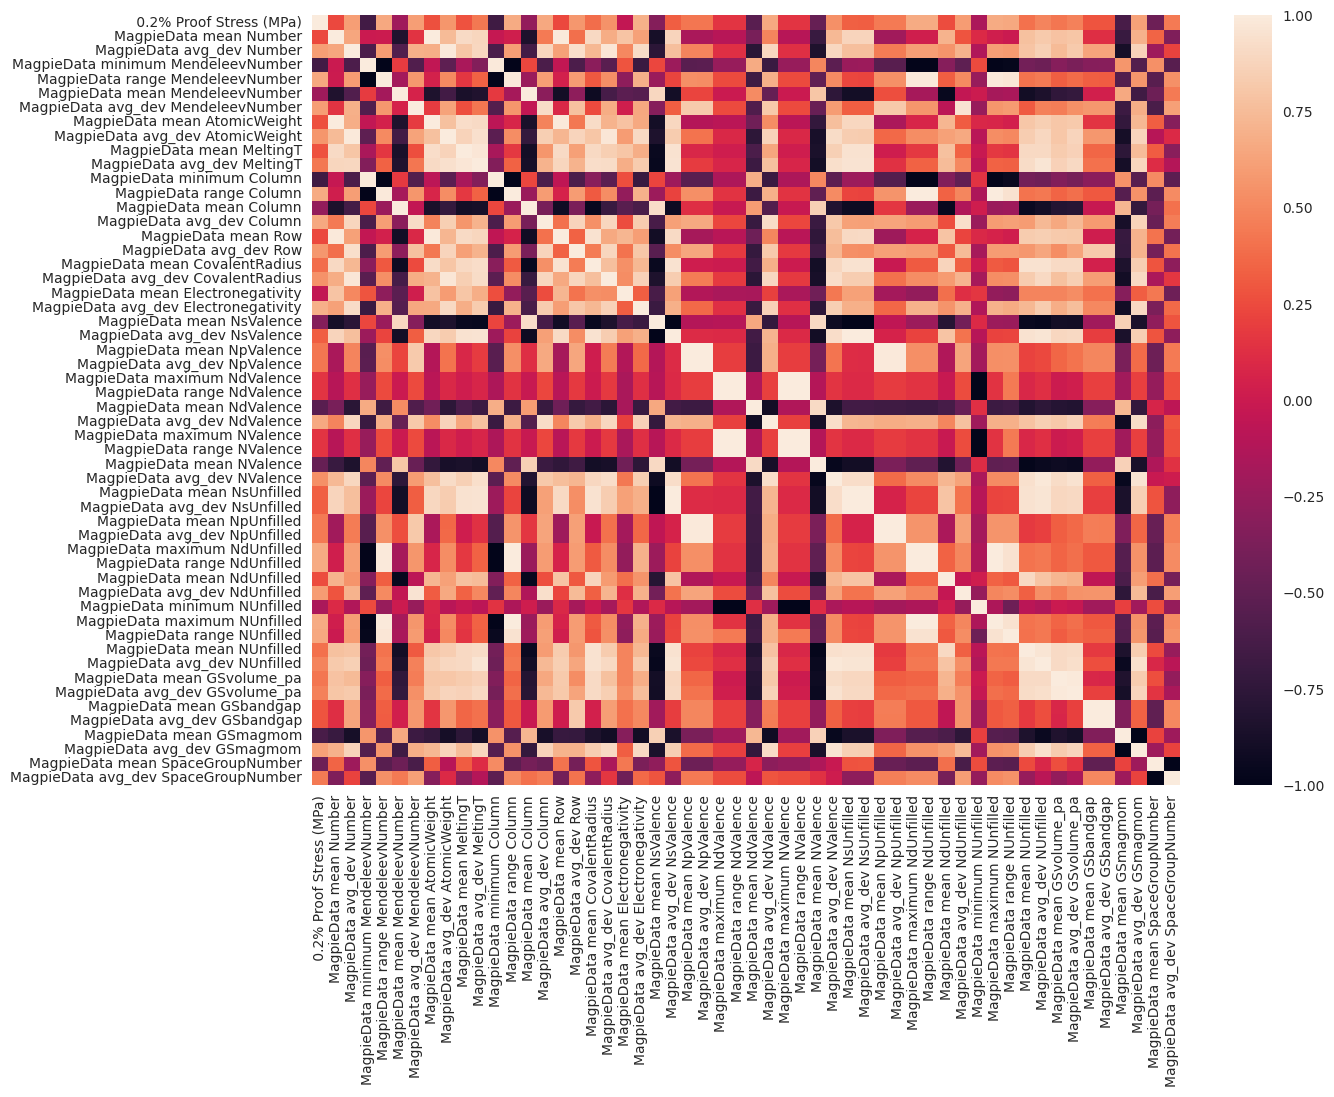

In [84]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(df_magpie.corr())

RMSE train: 78.29956576761798
RMSE test: 86.3554792771729
R2 score train: 0.6402394056034578
R2 score test: 0.6164731915338912


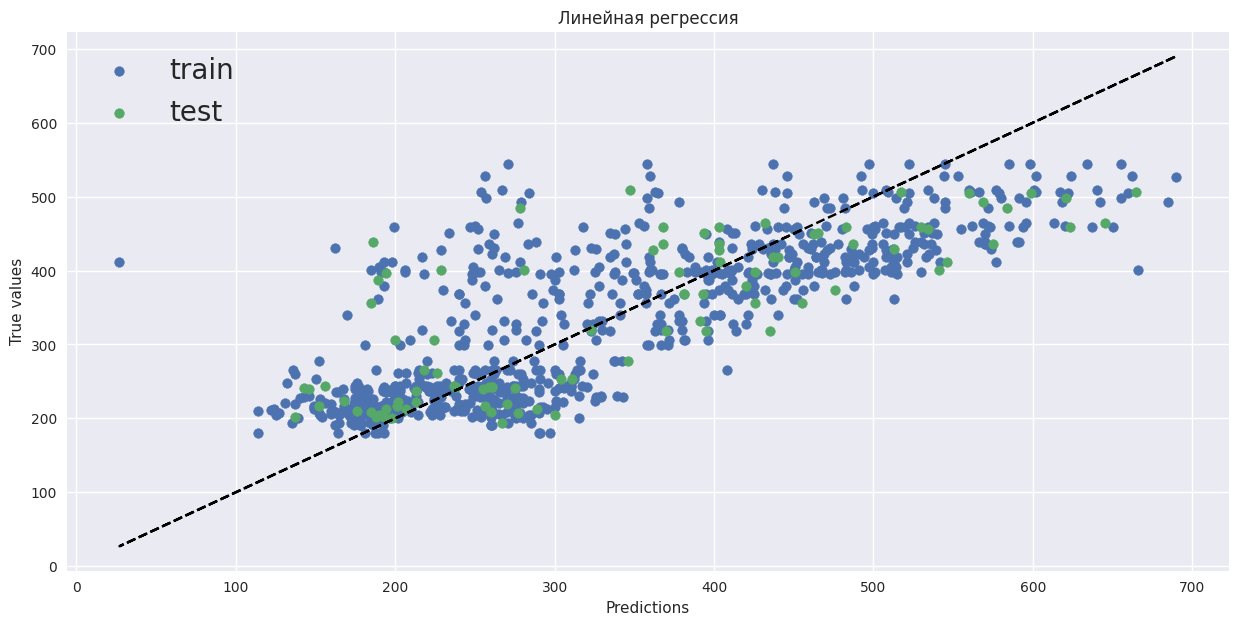

In [85]:
# разбивка данных на обучающую и тестовые выборки 



X = df_magpie.drop(' 0.2% Proof Stress (MPa)', axis=1)
Y = df_magpie[' 0.2% Proof Stress (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)

show_score(lr, X_train, X_test, y_train, y_test, title='Линейная регрессия')


RMSE train: 75.75829787494209
RMSE test: 88.95884269981997
R2 score train: 0.6632130135576484
R2 score test: 0.593000217202893


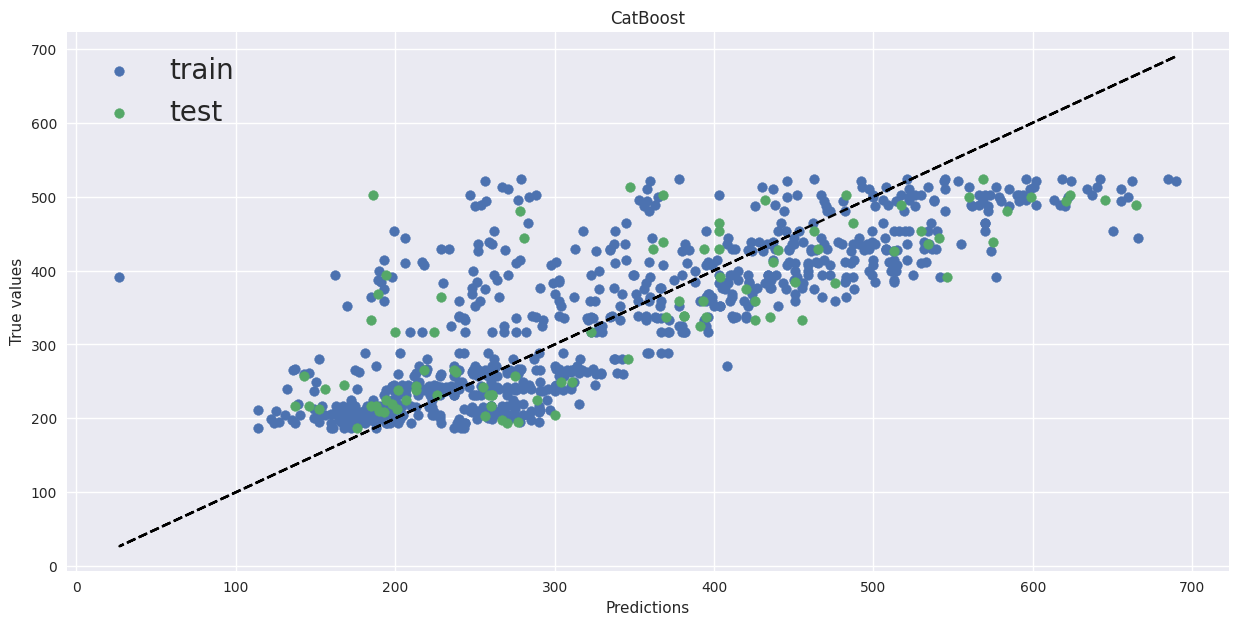

In [87]:
cat_boost = CatBoostRegressor()
cat_boost.fit(X_train, y_train, verbose=0)

show_score(cat_boost, X_train, X_test, y_train, y_test, title='СatBoost')

RMSE train: 78.8247866443409
RMSE test: 88.72892084121284
R2 score train: 0.6353967858855709
R2 score test: 0.5951013510138042


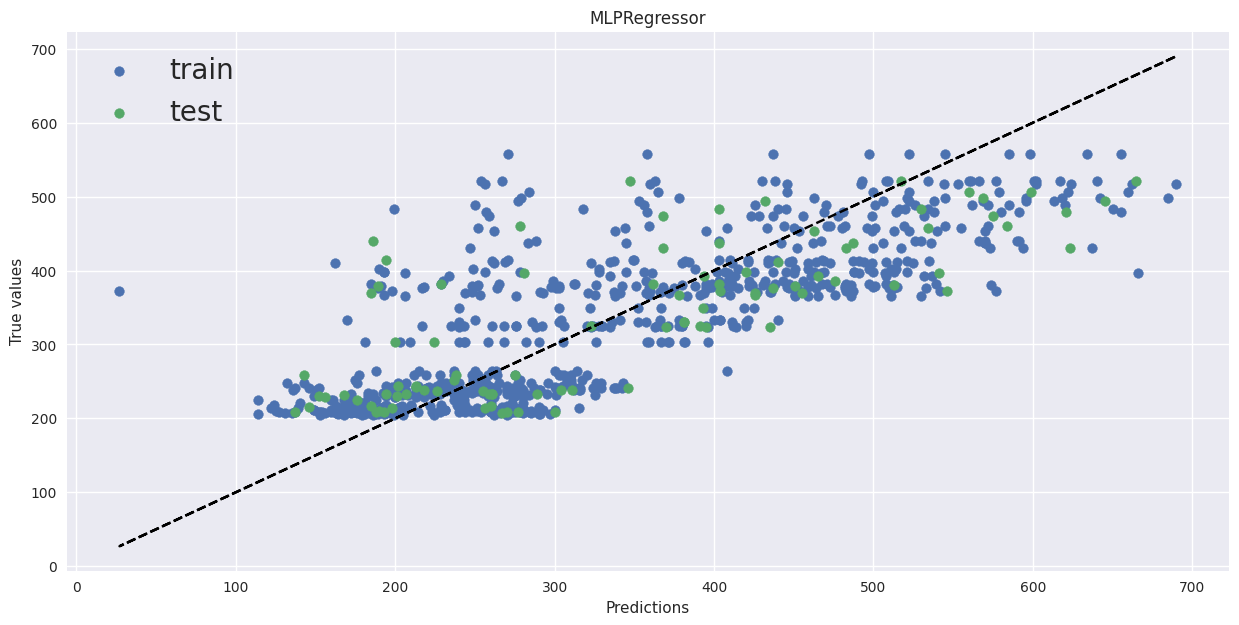

In [88]:
mlr = MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 
                                       64, 64, 64, 64, 64 ,64, 64, 64, 64, 64, 
                                       64 ,64, 64, 64, 64 ,64, 64, 64, 64, 64,), 
                   max_iter=1000)
mlr.fit(X_train, y_train)

show_score(mlr, X_train, X_test, y_train, y_test, 'MLPRegressor')

А давайте склеим концентрации и все, что набрал magpie

In [108]:
df_new = pd.merge(df2, df_magpie)
df_new.head()


Alloy code     C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V  \
0        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
1        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
2        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
3        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
4        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   

      Al       N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0  0.003  0.0066  0.0      0.0                 27                       342   
1  0.003  0.0066  0.0      0.0                 27                       342   
2  0.003  0.0066  0.0      0.0                100                       338   
3  0.003  0.0066  0.0      0.0                100                       338   
4  0.003  0.0066  0.0      0.0                100                       338   

    Tensile Strength (MPa)   Elongation (%)   Reduction in Area (%)  \
0                      490               30                      71   
1                      490               30                      71   
2                      454               27                      72   
3                      454               27                      72   
4                      454               27                      72   

   MagpieData mean Number  MagpieData avg_dev Number  \
0               26.005846                   0.201074   
1               25.941598                   0.169401   
2               26.005846                   0.201074   
3               26.024396                   0.321610   
4               25.900450                   0.205127   

   MagpieData minimum MendeleevNumber  MagpieData range MendeleevNumber  \
0                                49.0                              39.0   
1                                49.0                              39.0   
2                                49.0                              39.0   
3                                46.0                              42.0   
4                                46.0                              42.0   

   MagpieData mean MendeleevNumber  MagpieData avg_dev MendeleevNumber  \
0                        55.019672                            0.247696   
1                        55.109696                            0.305856   
2                        55.019672                            0.247696   
3                        55.018842                            0.362325   
4                        55.095640                            0.299910   

   MagpieData mean AtomicWeight  MagpieData avg_dev AtomicWeight  \
0                     55.894152                         0.499907   
1                     55.727260                         0.352050   
2                     55.894152                         0.499907   
3                     55.959025                         0.799820   
4                     55.638071                         0.428698   

   MagpieData mean MeltingT  MagpieData avg_dev MeltingT  \
0               1821.073435                    24.881903   
1               1809.802108                    10.819713   
2               1821.073435                    24.881903   
3               1825.846857                    37.011118   
4               1809.637367                    10.056995   

   MagpieData minimum Column  MagpieData range Column  MagpieData mean Column  \
0                        6.0                     10.0                7.996462   
1                        6.0                     10.0                8.028246   
2                        6.0                     10.0                7.996462   
3                        5.0                     11.0                7.991532   
4                        5.0                     11.0                8.021650   

   MagpieData avg_dev Column  MagpieData mean Row  MagpieData avg_dev Row  \
0                   0.073451             3.999818               

In [109]:
X = df_new.drop([' 0.2% Proof Stress (MPa)', 'Alloy code'], axis=1)
Y = df_new[' 0.2% Proof Stress (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


RMSE train: 40.165347609903414
RMSE test: 37.69351823695601
R2 score train: 0.8718072638484842
R2 score test: 0.8871563870041305


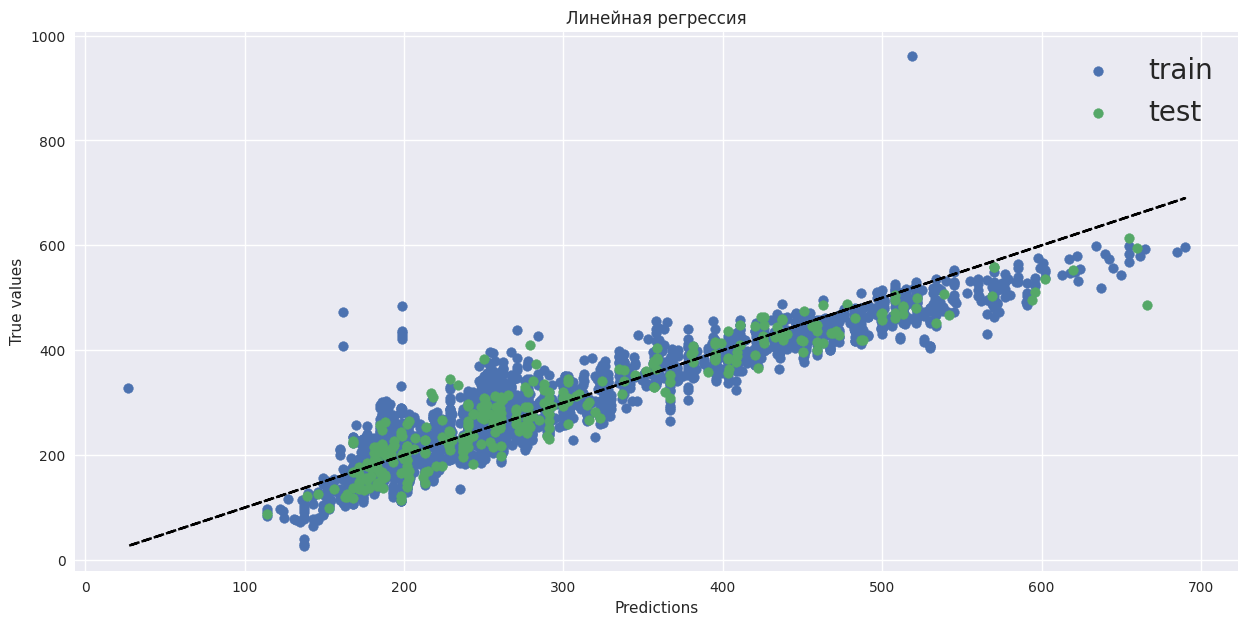

In [110]:

lr = LinearRegression()
lr.fit(X_train, y_train)

show_score(lr, X_train, X_test, y_train, y_test, title='Линейная регрессия')

RMSE train: 5.143785934840418
RMSE test: 10.830608969440453
R2 score train: 0.997897547800778
R2 score test: 0.9906835730220183


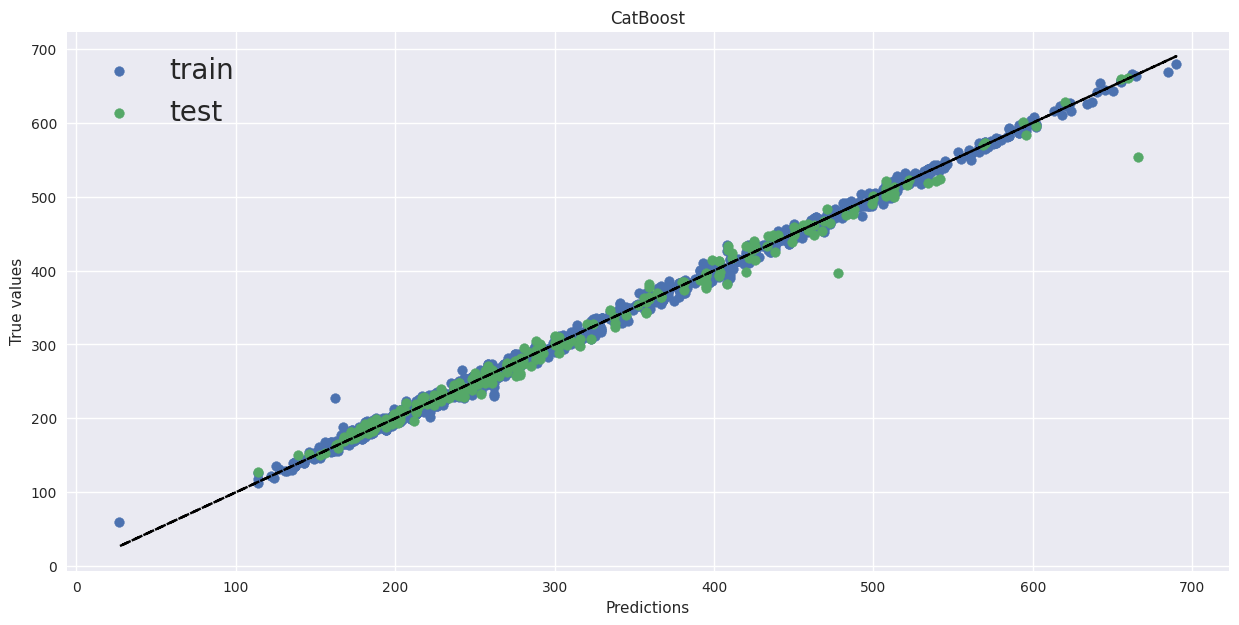

In [121]:
cat_boost = CatBoostRegressor()
cat_boost.fit(X_train, y_train, verbose=0)

show_score(cat_boost, X_train, X_test, y_train, y_test, title='СatBoost')

0_0

RMSE train: 16.027539069372274
RMSE test: 19.387048665481927
R2 score train: 0.9795876011421953
R2 score test: 0.9701484399257124


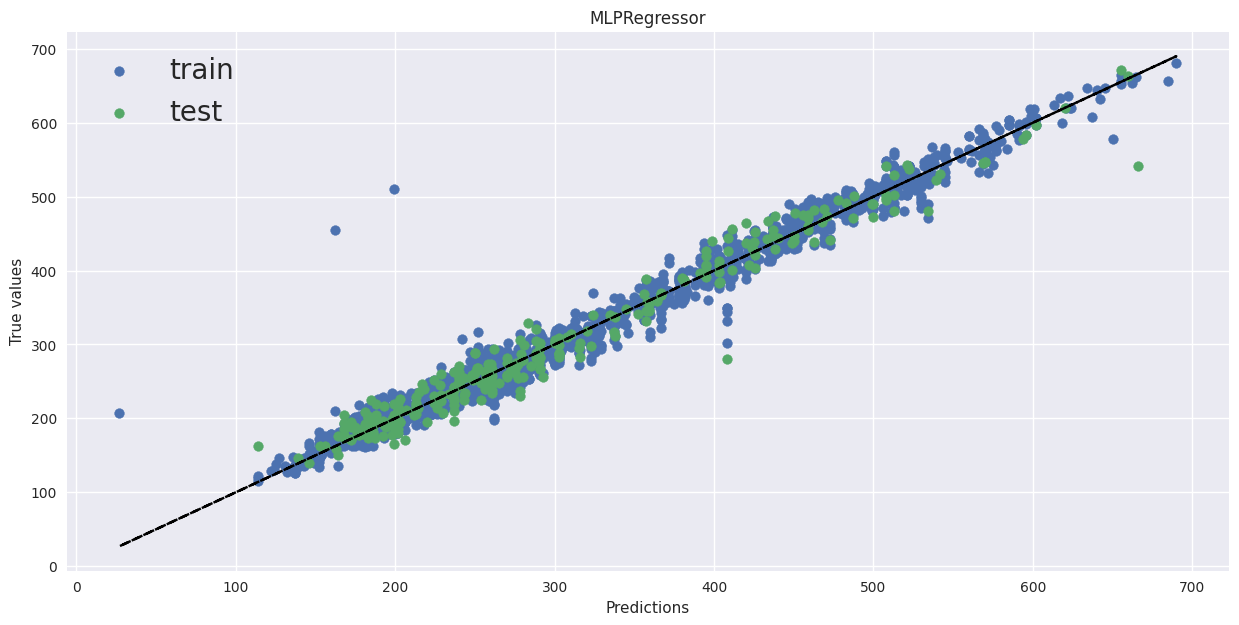

In [114]:
mlr = MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64, 64, 64, 64, 64, 64), 
                   max_iter=1000)
mlr.fit(X_train, y_train)

show_score(mlr, X_train, X_test, y_train, y_test, 'MLPRegressor')

RMSE train: 6.326819153255974
RMSE test: 13.42564664219918
R2 score train: 0.9968192378204652
R2 score test: 0.9856842516052743


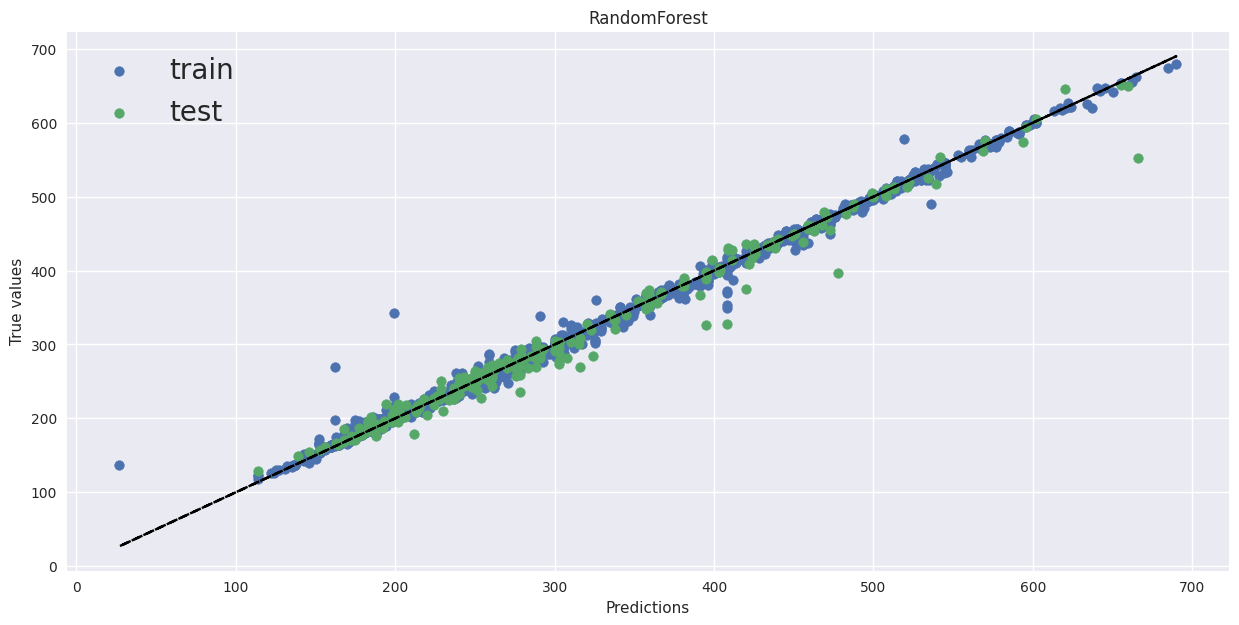

In [117]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

show_score(rf, X_train, X_test, y_train, y_test, 'RandomForest')

RMSE train: 6.118475130794197
RMSE test: 10.44306772227453
R2 score train: 0.9970252754632793
R2 score test: 0.9913383661593819


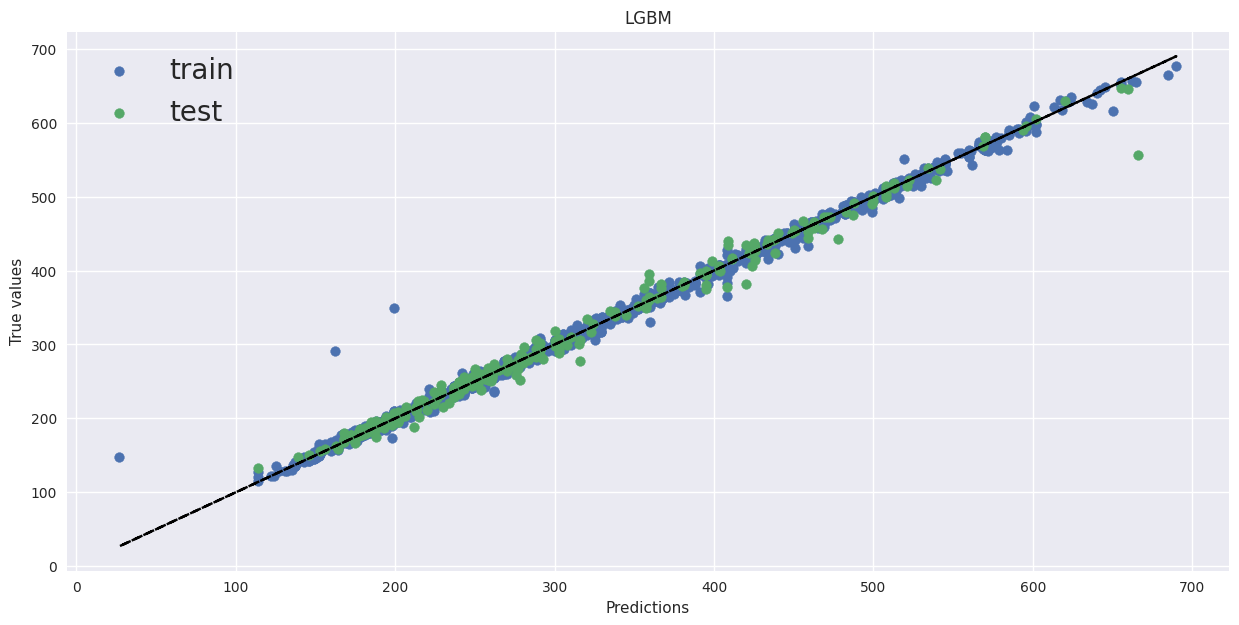

In [119]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=200, n_jobs=-1)
lgbm.fit(X_train, y_train)

show_score(lgbm, X_train, X_test, y_train, y_test, title='LGBM')

Самыми крутыми оказались градиентные бустинги, давайте посмотрим на кросс-валидацию

CatBoost

In [123]:
from IPython.display import clear_output
output = cross_validate(cat_boost, X_train, y_train, cv=5, scoring='r2')
clear_output()
output

{'fit_time': array([2.3348577 , 2.46608615, 2.32781672, 2.31798387, 2.35752368]),
 'score_time': array([0.00963426, 0.03181672, 0.03925657, 0.02675271, 0.02692437]),
 'test_score': array([0.99231299, 0.98266854, 0.9662861 , 0.99274567, 0.98744442])}

LGBM

In [124]:
from IPython.display import clear_output
output = cross_validate(lgbm, X_train, y_train, cv=5, scoring='r2')
clear_output()
output

{'fit_time': array([0.77986121, 0.353338  , 0.34048414, 0.41016102, 0.33226442]),
 'score_time': array([0.0032599 , 0.00481105, 0.00340891, 0.00992179, 0.00341892]),
 'test_score': array([0.99243907, 0.98241879, 0.96726252, 0.98838847, 0.9844587 ])}

Ну вообще они дают примерно одинаковую оценку

Проведем GridSearch

In [125]:
from sklearn.model_selection import GridSearchCV

In [128]:
model = CatBoostRegressor(verbose=0)  # verbose=0 отключает вывод в консоль

# Гиперпараметры для перебора
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Обучаем GridSearchCV
grid_search.fit(X_train, y_train)

# Результаты
print("Best params:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

# Оценка на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("RMSE test:", mse(y_test, y_pred) ** 0.5)
print("R2 score test:", r2_score(y_test, y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
Best RMSE: 15.941930899736821
RMSE test: 13.14492234733531
R2 score test: 0.9862766644768661


### Задание:

1. ~~Подобрать оптимальный набор элементных признаков и алгоритм машинного обучения (тот, который будет давать минимальную ошибку) для базы данных сталей steels_kaggle.~~
2. Визуализировать датасет с помощью метода сокращения размерности (PCA, t-SNE, UMAP). Сделать кластеризацию и отобразить различные кластеры. (не обязательно, если есть желание)



In [139]:
df_cut = df_new.drop('Alloy code', axis=1)
df_cut.head()


C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V     Al  \
0  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
1  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
2  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
3  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
4  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   

        N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0  0.0066  0.0      0.0                 27                       342   
1  0.0066  0.0      0.0                 27                       342   
2  0.0066  0.0      0.0                100                       338   
3  0.0066  0.0      0.0                100                       338   
4  0.0066  0.0      0.0                100                       338   

    Tensile Strength (MPa)   Elongation (%)   Reduction in Area (%)  \
0                      490               30                      71   
1                      490               30                      71   
2                      454               27                      72   
3                      454               27                      72   
4                      454               27                      72   

   MagpieData mean Number  MagpieData avg_dev Number  \
0               26.005846                   0.201074   
1               25.941598                   0.169401   
2               26.005846                   0.201074   
3               26.024396                   0.321610   
4               25.900450                   0.205127   

   MagpieData minimum MendeleevNumber  MagpieData range MendeleevNumber  \
0                                49.0                              39.0   
1                                49.0                              39.0   
2                                49.0                              39.0   
3                                46.0                              42.0   
4                                46.0                              42.0   

   MagpieData mean MendeleevNumber  MagpieData avg_dev MendeleevNumber  \
0                        55.019672                            0.247696   
1                        55.109696                            0.305856   
2                        55.019672                            0.247696   
3                        55.018842                            0.362325   
4                        55.095640                            0.299910   

   MagpieData mean AtomicWeight  MagpieData avg_dev AtomicWeight  \
0                     55.894152                         0.499907   
1                     55.727260                         0.352050   
2                     55.894152                         0.499907   
3                     55.959025                         0.799820   
4                     55.638071                         0.428698   

   MagpieData mean MeltingT  MagpieData avg_dev MeltingT  \
0               1821.073435                    24.881903   
1               1809.802108                    10.819713   
2               1821.073435                    24.881903   
3               1825.846857                    37.011118   
4               1809.637367                    10.056995   

   MagpieData minimum Column  MagpieData range Column  MagpieData mean Column  \
0                        6.0                     10.0                7.996462   
1                        6.0                     10.0                8.028246   
2                        6.0                     10.0                7.996462   
3                        5.0                     11.0                7.991532   
4                        5.0                     11.0                8.021650   

   MagpieData avg_dev Column  MagpieData mean Row  MagpieData avg_dev Row  \
0                   0.073451             3.999818                0.012562   
1                   0.086090             3.994354        

In [131]:
from umap.umap_ import UMAP

X_umap = UMAP(n_components=2).fit_transform(df_cut)

2024-12-22 08:54:07.101599: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 08:54:07.450796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 08:54:07.450839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 08:54:07.452247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 08:54:07.590059: I tensorflow/core/platform/cpu_feature_g

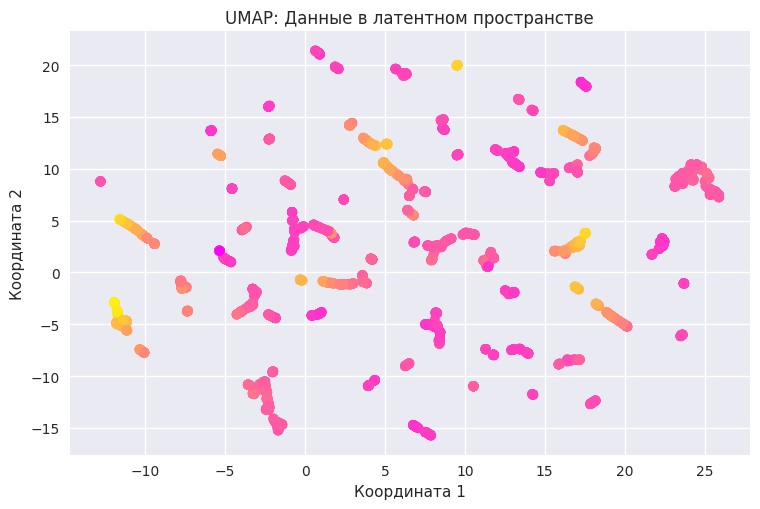

In [133]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_new[' 0.2% Proof Stress (MPa)'], cmap='spring')
plt.xlabel('Координата 1')
plt.ylabel('Координата 2')
plt.title('UMAP: Данные в латентном пространстве')
plt.tight_layout()

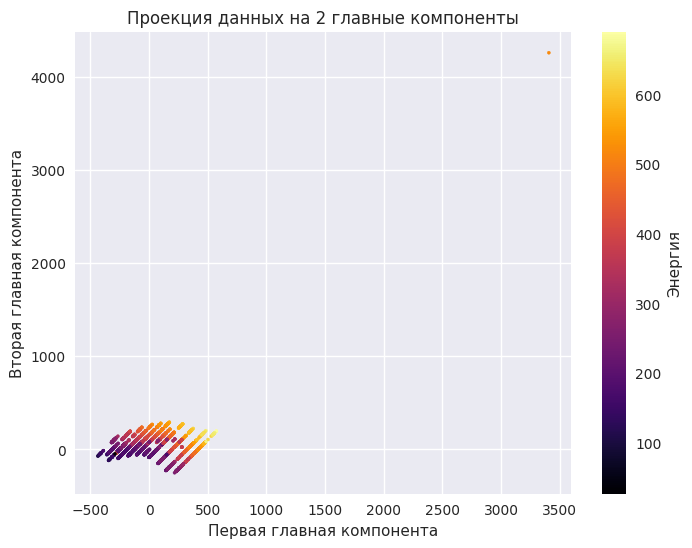

In [134]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cut)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new[' 0.2% Proof Stress (MPa)'], cmap='inferno', s=5)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Энергия')
plt.title('Проекция данных на 2 главные компоненты')
plt.show()


Тут вспоминаем, что там же был выброс 

In [144]:
df_new = df_new[df_new[' Tensile Strength (MPa)'] < 1000] # (см. lesson2.ipynb)
df_cut = df_new.drop('Alloy code', axis=1)
df_cut.head()


C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V     Al  \
0  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
1  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
2  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
3  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   
4  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0  0.003   

        N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0  0.0066  0.0      0.0                 27                       342   
1  0.0066  0.0      0.0                 27                       342   
2  0.0066  0.0      0.0                100                       338   
3  0.0066  0.0      0.0                100                       338   
4  0.0066  0.0      0.0                100                       338   

    Tensile Strength (MPa)   Elongation (%)   Reduction in Area (%)  \
0                      490               30                      71   
1                      490               30                      71   
2                      454               27                      72   
3                      454               27                      72   
4                      454               27                      72   

   MagpieData mean Number  MagpieData avg_dev Number  \
0               26.005846                   0.201074   
1               25.941598                   0.169401   
2               26.005846                   0.201074   
3               26.024396                   0.321610   
4               25.900450                   0.205127   

   MagpieData minimum MendeleevNumber  MagpieData range MendeleevNumber  \
0                                49.0                              39.0   
1                                49.0                              39.0   
2                                49.0                              39.0   
3                                46.0                              42.0   
4                                46.0                              42.0   

   MagpieData mean MendeleevNumber  MagpieData avg_dev MendeleevNumber  \
0                        55.019672                            0.247696   
1                        55.109696                            0.305856   
2                        55.019672                            0.247696   
3                        55.018842                            0.362325   
4                        55.095640                            0.299910   

   MagpieData mean AtomicWeight  MagpieData avg_dev AtomicWeight  \
0                     55.894152                         0.499907   
1                     55.727260                         0.352050   
2                     55.894152                         0.499907   
3                     55.959025                         0.799820   
4                     55.638071                         0.428698   

   MagpieData mean MeltingT  MagpieData avg_dev MeltingT  \
0               1821.073435                    24.881903   
1               1809.802108                    10.819713   
2               1821.073435                    24.881903   
3               1825.846857                    37.011118   
4               1809.637367                    10.056995   

   MagpieData minimum Column  MagpieData range Column  MagpieData mean Column  \
0                        6.0                     10.0                7.996462   
1                        6.0                     10.0                8.028246   
2                        6.0                     10.0                7.996462   
3                        5.0                     11.0                7.991532   
4                        5.0                     11.0                8.021650   

   MagpieData avg_dev Column  MagpieData mean Row  MagpieData avg_dev Row  \
0                   0.073451             3.999818                0.012562   
1                   0.086090             3.994354        

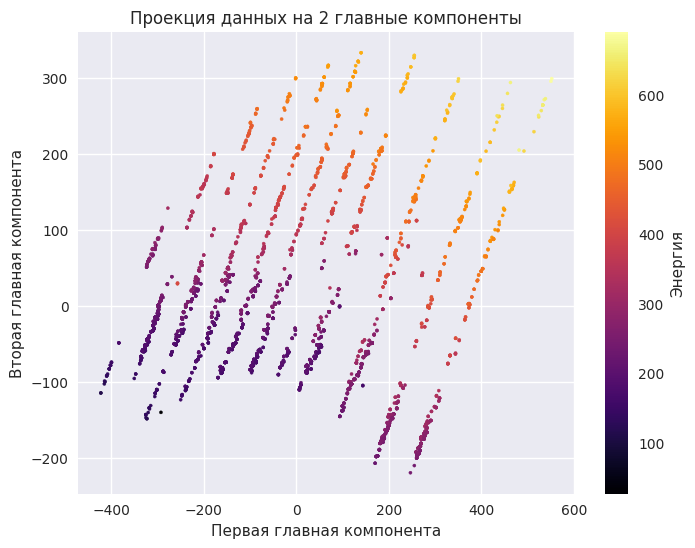

In [145]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cut)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new[' 0.2% Proof Stress (MPa)'], cmap='inferno', s=5)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Энергия')
plt.title('Проекция данных на 2 главные компоненты')
plt.show()


По UMAP образовывались какие-то небольшие кластеры, но в целом, как будто кластеризацию по непрерывно зависящему от параметров таргету не совсем имеет смысл делать.